# Module 2 - Tuning Neural Networks
***


# Introduction

In the last module we introduced **artificial neural networks and trained our first neural networks**.
- These were shallow nets, with just a few hidden layers.

If you need to tackle a complex problem, such as **detecting hundreds of types of objects in high-resolution images**, you may need to train a much deeper DNN:
- perhaps with 100 layers or many more,
- each containing hundreds of neurons,
- linked by hundreds of thousands of connections.

Training a deep DNN isn’t a walk in the park. Here are some of the problems you could run into:
- **Vanishing/Exploding gradients problem:** This is when the gradients grow smaller and smaller, or larger and larger, when flowing backward through the DNN during training.

- **Lack of training data:** You might not have enough training data for such a large network, or it might be too costly to label.

- **Slow Training:** With massive neural network with million of parameters, training can take a long time, especially if you don't have access to high powered GPUs.

- **Overfitting:** A model with millions of parameters would severely risk **overfitting the training set**, especially if there are not enough training instances or if they are too noisy.


# Learning Outcomes

In this module, you will:

* Explore the vanishing gradient problem and some of the most popular solutions to this problem

* Become familiar with various optimizers that can speed up the training of large models tremendously compared to basic gradient descent

* Be introduced to a few popular regularization techniques for large neural networks

* Gain an improved understanding of why and how neural networks are optimized

* Understand how performance is quantified for neural networks, and how this can be used to tune them

* Learn how to use manual and automated approaches for neural network parameter tuning

**SETUP**

In [5]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Vanishing/Exploding Gradients Problem

## Overview


As we discussed in the last module, the backpropagation algorithm works by going from the **output layer to the input layer, propagating the error gradient along the way**. Once the algorithm has computed **the gradient of the cost function with regard to each parameter in the network**, it uses these gradients to update each parameter with a Gradient Descent step.

This is worth summarizing once more:
1. **Forward Pass:**
    - Each mini-batch is passed to the network’s input layer, which sends it to the first hidden layer. The algorithm then computes the output of all the neurons in this layer (**for every instance in the mini-batch**).
    - The result is passed to the next layer, its output is computed and passed to the next layer, and so on until we get the output of the last layer, the output layer.
    - This process is **exactly like making predictions,** except all intermediate results are preserved since they are needed for the backward pass.
2. **Calculate Loss (error):**
    - The algorithm measures the **network’s output error**; it uses a loss function that compares the desired output and the actual output of the network.
3. **Backward Pass:**
    - Then algorithm first computes how much each output connection contributed to the error **(the derivatives)**. This is done analytically by applying the **chain rule**, which makes this step fast and precise.
    - The algorithm then measures how much of these error contributions came from each connection in the **layer below**, again using the chain rule, **working backward until the algorithm reaches the input layer**.
    - This reverse pass efficiently **measures the error gradient across all the connection weights in the network** by propagating the error gradient backward through the network.
    - Tensorflow uses reverse mode autodiff for this process (see Appendix D of the textbook).
4.  **Gradient Descent Step:**
    - The algorithm performs a Gradient Descent step to tweak all the connection weights in the network, using the error gradients it just computed.

<div align="center">
<img src="https://drive.google.com/uc?id=1fQmUQBwdJeEmOqwmCEe6L4DJV29zFywB" style="width:650px">
</div>


Unfortunately, **gradients often get smaller and smaller as the algorithm progresses down to the lower layers ('lower' means closer to the inputs)**.
- The Gradient Descent update leaves the lower layers’ connection weights virtually unchanged
- This means that training never converges to a good solution.
- We call this the **vanishing gradients problem.**

In some cases, the opposite can happen:
- the gradients can grow bigger and bigger until layers get insanely large weight updates and the algorithm diverges.
- This is the **exploding gradients problem**, which surfaces in recurrent neural networks.

More generally, deep neural networks suffer from **unstable gradients**:
- Different layers may **learn at widely different speeds.**
- This unfortunate behavior was empirically observed long ago, and it was one of the reasons deep neural networks were mostly abandoned in the early 2000s.


In 2010, Xavier Glorot and Yoshua Bengio released a breakthrough paper addressing this issue. The authors found a few suspects:
1. The logistic sigmoid activation function
2. The random normal weight initialization technique (a normal distribution with a mean of 0 and a standard deviation of 1).

Both of these techniques were standard practice at the time, and the authors showed that in combination (using both the sigmoid activation function and random normal initialization scheme):
- The variance of the outputs of each layer is much greater than the variance of its inputs.
- Going forward in the network, the **variance keeps increasing after each layer until the activation function saturates at the top layers (closer to the ouput)**.
- This saturation is actually made worse by the fact that the logistic function has a mean of 0.5, not 0 (the hyperbolic tangent function has a mean of 0 and behaves slightly better than the logistic function in deep networks).

In [12]:
def logit(z):
    return 1 / (1 + np.exp(-z))

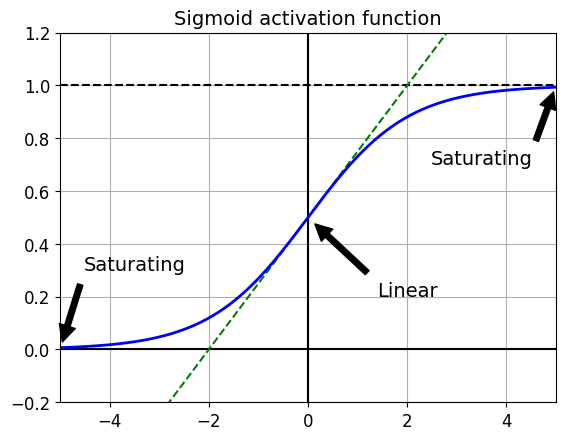

In [13]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])
plt.show()

Looking at the logistic activation function above:
- When inputs become large (negative or positive), the function saturates at 0 or 1, with a derivative extremely close to 0.

<div align="center">
<img src="https://drive.google.com/uc?id=1d_f-NrDsv8NA9e2Ul_iJGGLDfBReWlwv" >
</div>


Thus, when backpropagation kicks in **there is virtually no gradient to propagate back through the network**;
- Per the chain rule, the **derivative with respect to a particular W matrix is the product of the partial derivatives of the layers above it**.
- In essence, we keep **multiplying small partial derivatives by even smaller partial derivatives**
- When we get to the bottom layers (close to the inputs), the derivatives are **too small to make meaningful changes when we perform a gradient descent step.**
    
  
<div align="center">
<img src="https://drive.google.com/uc?id=1D-dJBdIYb6y4dKpK7NVEBYk49nilN8e4" style="width:650px;height:250px;">
</div>




To illustrate this mathematically, consider the 2-layer network illustrated above (we'll treat the bias term $b$ as if it's part of the weights term $W$ for convenience). The forward propagation is given by:


$z_{1}=W_{1}x_{1} \rightarrow a_{1}=\sigma(z_{1}) \rightarrow z_{2} = W_{2}a_{1} \rightarrow a_{2}=\sigma(z_{2}) \rightarrow L$


The gradient for the last hidden layer is:


<font size="5">
$\frac{\partial{L}}{\partial{W_{2}}}=\frac{\partial{L}}{\partial{a_{2}}}\frac{\partial{a_{2}}}{\partial{z_{2}}}\frac{\partial{z_{2}}}{\partial{W_{2}}}$
</font>


Note that the second term on the right-hand-side is the derivative of the activation function for this layer, which could be close to zero if $a_{2}=\sigma(z_{2})$ was saturated.

The gradient for the second-last hidden layer is:

<font size="5">
$\frac{\partial{L}}{\partial{W_{1}}}=\frac{\partial{L}}{\partial{a_{2}}}\frac{\partial{a_{2}}}{\partial{z_{2}}}\frac{\partial{z_{2}}}{\partial{a_{1}}}\frac{\partial{a_{1}}}{\partial{z_{1}}}\frac{\partial{z_{1}}}{\partial{W_{1}}}$
</font>


Note that now we have BOTH the derivative of the activation from the last hidden layer $\frac{\partial{a_{2}}}{\partial{z_{2}}}$ AND the current layer $\frac{\partial{a_{1}}}{\partial{z_{1}}}$. So if both of these derivatives are small numbers, than the total gradient for the second last layer will be smaller than the gradient of the layer ahead of it. And this trend will continue as we backpropagate further to earlier layers in the network.

To further illustrate this problem, we will develop a simple model that takes in a `layer` parameter, and dynamically updates the graph with the specified number of dense layers.

We then extract the value of the weight gradients at the *first layer*. As you will see, **when the number of layers gets larger, the value of the gradients at the *first* layer gets smaller and smaller.**

In [14]:
import tensorflow as tf

def mnist_fashion_clean(print_shapes=True):
    fashion_mnist = tf.keras.datasets.fashion_mnist
    (X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

    X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
    X_test = X_test / 255.
    # Convert types
    X_train = X_train.astype('float32')
    X_valid = X_valid.astype('float32')
    X_test = X_test.astype('float32')
    if print_shapes:
        print("X_trian:", X_train.shape)
        print("X_valid:", X_valid.shape)
        print("X_test:", X_test.shape)
        print("X_train stats:",X_train.mean(), X_train.std())
        print("X_valid stats:",X_valid.mean(), X_valid.std())
        print("X_test stats:",X_test.mean(), X_test.std())
    return X_train, X_valid, X_test, y_train, y_valid, y_test

X_train, X_valid, X_test, y_train, y_valid, y_test = mnist_fashion_clean()

X_trian: (55000, 28, 28)
X_valid: (5000, 28, 28)
X_test: (10000, 28, 28)
X_train stats: 0.28603044 0.35290107
X_valid stats: 0.2861465 0.35437852
X_test stats: 0.28684944 0.3524442


In [18]:
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np

tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

def layer1_gradients(layers, n_neurons=32, activation='sigmoid',
                     init='random_normal', verbose=True, return_grad=False):
    """Function for printing average L1 Gradient Values"""
    # Build Model
    inp = Input(shape=(28,28))
    X = Flatten()(inp)
    for l in range(layers):
        X = Dense(n_neurons, activation=activation, kernel_initializer=init)(X)
    out = Dense(10, activation="softmax")(X)

    # Compile Model
    model = Model(inputs=inp, outputs=out)

    # Get Layer L-1 output (using Model instead of K.function)
    get_layer_L = Model(inputs=model.input, outputs=model.layers[-1].output)
    out_vals = get_layer_L(X_train)   # directly pass data

    # Calculate gradients of first layer
    with tf.GradientTape() as tape:
        y_preds = model(X_train)
        model_loss = tf.keras.losses.sparse_categorical_crossentropy(y_train, y_preds)
    model_gradients = tape.gradient(model_loss, model.trainable_variables)

    L1_grad = np.mean(np.abs(model_gradients[0]))
    LL_grad = np.mean(np.abs(model_gradients[-1]))

    if verbose:
        print(f"L={layers}  ",
              "Layer_1 Mean Gradient: {:.7f}  ".format(L1_grad),
              "Layer_L Mean Gradient: {:.2f}  ".format(LL_grad),
              "Layer_L Output Mean: {:.2f}  ".format(out_vals.numpy().max(axis=1).mean())
             )
    if return_grad:
        return L1_grad


for i in range(3,10):
    layer1_gradients(i)


L=3   Layer_1 Mean Gradient: 0.9903818   Layer_L Mean Gradient: 2587.86   Layer_L Output Mean: 0.22  
L=4   Layer_1 Mean Gradient: 0.0523101   Layer_L Mean Gradient: 1631.66   Layer_L Output Mean: 0.17  
L=5   Layer_1 Mean Gradient: 0.0036633   Layer_L Mean Gradient: 3294.37   Layer_L Output Mean: 0.25  
L=6   Layer_1 Mean Gradient: 0.0004412   Layer_L Mean Gradient: 2379.23   Layer_L Output Mean: 0.18  
L=7   Layer_1 Mean Gradient: 0.0000201   Layer_L Mean Gradient: 1457.13   Layer_L Output Mean: 0.20  
L=8   Layer_1 Mean Gradient: 0.0000013   Layer_L Mean Gradient: 2371.26   Layer_L Output Mean: 0.19  
L=9   Layer_1 Mean Gradient: 0.0000002   Layer_L Mean Gradient: 4758.84   Layer_L Output Mean: 0.35  


So we see from the above that the mean gradient in the first layer rapidly shrinks as we add more layers. Next, let's view the impact this actually has on model performance. We will train a model and display its learning curves, for different numbers of layers. Note that we're using `sigmoid` as the activation function for all the hidden layers, and random normal initialization for the weights.

In [ ]:
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from time import time
K.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

def layer1_gradients_train(layers, n_neurons=32, activation='sigmoid', init='random_normal', epochs=100):
    """Function for printing average L1 Gradient Values and training the model"""
    optimizer = tf.keras.optimizers.Adam(lr=0.01)
    inp = Input(shape=(28,28))
    # Build Model
    X = Flatten()(inp)
    for l in range(layers):
        X = Dense(n_neurons, activation=activation, kernel_initializer=init)(X)
    out = Dense(10, activation="softmax")(X)
    model = Model(inputs=[inp], outputs=[out])
    get_layer_L = K.function([model.input], [model.layers[-1].output])
    # Training step function
    def step(real_x, real_y, verbose=False):
        with tf.GradientTape() as tape:
            y_preds = model(X_train)
            model_loss = tf.keras.losses.sparse_categorical_crossentropy(y_train, y_preds)
        model_gradients = tape.gradient(model_loss, model.trainable_variables)
        out = get_layer_L([X_train])
        L1_grad = np.mean(np.abs(model_gradients[0]))
        LL_grad = np.mean(np.abs(model_gradients[-1]))
        if verbose:
            print(f"L={len(model.layers)//2}  ",
                  "Layer_1 Mean Gradient: {:.7f}  ".format(L1_grad),
                  "Layer_L Mean Gradient: {:.2f}  ".format(LL_grad),
                  "Layer_L Output Mean: {:.2f}  ".format(out[0].max(axis=1).mean())
                 )
        # Update model parameters
        optimizer.apply_gradients(zip(model_gradients, model.trainable_variables))
        return np.mean(model_loss)
    losses = []
    accs = []
    verbose=False
    for epoch in range(epochs):
        if epoch%10==0:
            print("EPOCH ", epoch)
            verbose=True
        loss = step(X_train, y_train, verbose=verbose)
        verbose=False
        losses.append(loss)
        preds = model.predict(X_test)
        acc = sum(preds.argmax(axis=1)==y_test)/len(preds)
        accs.append(acc)

    print("FINAL LOSS:", loss, "FINAL ACCURACY:", acc)
    plt.plot(losses, label='losses')
    plt.plot(accs, label='accs')
    plt.legend()

In [ ]:
# train for 2 hidden layers
# (NOTE : TAKES A FEW MINUTES!)
tf.autograph.set_verbosity(0)
layer1_gradients_train(2)

In [ ]:
# train for 4 hidden layers
layer1_gradients_train(4)

In [ ]:
# training the same model for 6 hidden layers,
# I think you get the point! Model performance suffers due to vanishing gradients
layer1_gradients_train(6)

## Xavier (Glorot) and He Initialization



To address this issue, Glorot and Bengio proposed two solutions:
1. The variance of the outputs of each layer should be equal to the variance of its inputs
2. The gradients should have equal variance before and after flowing through a layer in reverse direction


It is actually **not possible to guarantee both unless the layer has an equal number of input and output connections**. However the authors proposed a good compromise that has proven to work very well in practice: **Xavier or Glorot Initialization**.

To immplement Glorot initialization, randomly initialize connections weights according to the equation below, where `n_inputs` and `n_outputs` are the number of input and output connections for the layer whose weights are being initialized:
- *Normal distribution* with mean of 0 and standard deviation of  $\sigma=\sqrt{\frac{2}{\text{n_inputs + n_outputs}}}$

    or

- *Uniform distribution* with between $-r$ and $r$ where $r=\sqrt{\frac{6}{\text{n_inputs + n_outputs}}}$


Using the Xavier initialization strategy can **speed up training considerably**, and it is one of the tricks that has led to the current success of Deep Learning.

Some recent papers have provided **similar strategies for different activation functions**, as shown in the table below. The initialization strategy for the ReLU activation function (and its variants, including the ELU activation described shortly) is sometimes called **He initialization** (after the last name of its author).

<div align="center">
<img src="https://drive.google.com/uc?id=1DKpYt6EwjcM6ELUsfn72PNyfEWutXW6Q" style="width:500px;">
</div>


In [ ]:
fan_in = 784 # Number of inputs (features)
fan_out = 1 # Number of neurons
fan_avg = (fan_in+fan_out)/2.0

glorot_sigma = np.sqrt(1/fan_avg)

X = np.random.normal(size=(1,fan_in))
print("Input shape:", X.shape)
print("Glorot Sigma:", glorot_sigma)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

W_random = np.random.normal(loc=0, scale=1, size=(fan_in, fan_out))
random_out_Z = X.dot(W_random)
random_out_A = sigmoid(random_out_Z)
print("\nRandom Output Z:", random_out_Z)
print("Random Output A:", random_out_A)

W_glorot = np.random.normal(loc=0, scale=glorot_sigma, size=(fan_in, fan_out))
glorot_out_Z = X.dot(W_glorot)
glorot_out_A = sigmoid(glorot_out_Z)
print("\nGlorot Output Z:", glorot_out_Z)
print("Glorot Output A:", glorot_out_A)

Here is the fundamental intuition:
- By **scaling the weights** based on the number of inputs and outputs, we are ensuring that the output of the linear activation will be **within a range such that the non-linear activation is not saturated**.

In [ ]:
# when initializing our weights, ideally we want a layer's activation
# to start near the middle of its range (0.5 for a sigmoid),
# to avoid saturation; below, we randomly generate our weights 1000 times,
# and show histograms of the possible activations obtained under different
# weight initialization schemes

fan_in = 784 # Number of inputs
fan_out = 32 # Number of neurons

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

glorot_means = []
random_means = []
glorot_vars = []
random_vars = []

X = np.random.normal(size=(1,fan_in))

for i in range(1000):
    fan_avg = (fan_in+fan_out)/2.0
    glorot_sigma = np.sqrt(1/fan_avg)
    W_glorot = np.random.normal(loc=0, scale = glorot_sigma, size=(fan_in, fan_out))
    W_random = np.random.normal(loc=0, scale = 1, size=(fan_in, fan_out))
    glorot_out = sigmoid(X.dot(W_glorot))
    random_out = sigmoid(X.dot(W_random))
    glorot_means.append(glorot_out.mean())
    random_means.append(random_out.mean())
    glorot_vars.append(glorot_out.var())
    random_vars.append(random_out.var())

print("Random Output Variance:", np.mean(random_vars))
print("Glorot Output Variance:", np.mean(glorot_vars))

plt.hist(glorot_means, bins=100, alpha=0.5, label='glorot')
plt.hist(random_means, bins=100, alpha=0.5, label='random_normal')
plt.legend()

plt.show()

The histograms above show that, with random normal initialization of weights, we are more likely to produce an initial activation that is in the 'saturating' region of our activation function, where the derivative (and therefore gradient update) will be small.

In [ ]:
# let's take a look at the different initializers available
from tensorflow import keras
[name for name in dir(keras.initializers) if not name.startswith("_")]

By default, Keras uses `GlorotUniform`.

When creating a layer, you can change this to He initialization by setting `kernel_initializer="he_uniform"` or `kernel_initializer="he_normal"` like this:

In [ ]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

If you want He initialization with a uniform distribution but based on `fan avg` rather than `fan in` , you can use the `VarianceScaling` initializer like this:

In [ ]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg', distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

Now let's plot the Layer_1 mean gradient as a function of number of hidden layers (N) for different initialization and activation function strategies.

In [ ]:
K.clear_session()
np.random.seed(23)
tf.random.set_seed(23)

rn_grads_sig = []
he_grads_sig = []
gx_grads_sig = []
rn_grads = []
he_grads = []
gx_grads = []
for i in range(1,10):
    rn_grads_sig.append(layer1_gradients(i, return_grad=True, activation='sigmoid', init='random_normal', verbose=False))
    gx_grads_sig.append(layer1_gradients(i, return_grad=True, activation='sigmoid', init='glorot_normal', verbose=False))
    he_grads_sig.append(layer1_gradients(i, return_grad=True, activation='sigmoid', init='he_uniform', verbose=False))
    rn_grads.append(layer1_gradients(i, return_grad=True, activation='relu', init='random_normal', verbose=False))
    gx_grads.append(layer1_gradients(i, return_grad=True, activation='relu', init='glorot_normal', verbose=False))
    he_grads.append(layer1_gradients(i, return_grad=True, activation='relu', init=keras.initializers.VarianceScaling(scale=2, mode='fan_avg', distribution='uniform'), verbose=False))

In [ ]:
plt.plot(rn_grads_sig, label='rn_sig')
plt.plot(he_grads_sig, label='he_sig')
plt.plot(gx_grads_sig, label='gx_sig')
plt.plot(rn_grads , label='rn_relu')
plt.plot(he_grads , label='he_relu')
plt.plot(gx_grads , label='gx_relu')
plt.xlabel('N Layers')
plt.title('Mean Absolute Gradient of L1')
plt.legend()
plt.show()

As we can see, the layer one gradients suffer from saturation to a much lesser degree when glorot initializtion is applied.
- This affect will change based on the data and activation function you choose
- In general **Xavier/Glorot is the best place to start** (or He initialization if you are using ReLU or ReLU relatives).

To hammer this point home, let's train a bunch of models using different initialization strategies and observe how the accuracy changes on each iteration (using ReLU as our base activation function):
- To do this, we create a wrapper function that creates a simple feedforward network with **5 layers**.
- We will include `activation` and `initializer` parameters so we can test multiple models.

In [ ]:
from tensorflow.keras import layers

# Initialize simple_model function
def simple_model(initializer, activation='relu'): # Use relu as base activation function
    return tf.keras.Sequential([layers.Flatten(),
                                layers.Dense(32, activation, input_shape=(784,), kernel_initializer=initializer),
                                layers.Dense(32, activation, kernel_initializer=initializer),
                                layers.Dense(32, activation, kernel_initializer=initializer),
                                layers.Dense(32, activation, kernel_initializer=initializer),
                                layers.Dense(10, activation='softmax', kernel_initializer=tf.keras.initializers.glorot_normal())])

**Zeros initialization**

In the last module, we mentioned that if we set all of our weights to zeros before our first iteration of backpropagation, your neural network won't be able to converge at all:
- Using 'zeros initialization' will cause all of the hidden units to be **completely identical (symmetric)**
    - they will compute exactly the same function.
- On each gradient descent iteration **all of the hidden units will always have the same update values**:
    - if all hidden units remain the same we won't get any additional value from having multiple neurons (thus defeating the purpose of using a neural network)!

Let's demonstrate this below:

In [ ]:
X_train, X_valid, X_test, y_train, y_valid, y_test = mnist_fashion_clean()

In [ ]:
# Set params
init = tf.keras.initializers.Zeros()
activate = 'relu'

# Run model
optimizer = tf.keras.optimizers.SGD(0.01)
model_ze = simple_model(init, activate)
model_ze.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_ze.fit(X_train, y_train, epochs=10, batch_size=3200, validation_data=(X_valid, y_valid))

In [ ]:
ws = model_ze.get_weights()
ws[4]

In [ ]:
# Set all layers to different values
# But each layer's neurons are the exact same
for i in range(len(ws)):
    ws[i] += 0.2* np.random.rand()
#     ws[i] = np.random.random(size=(ws[i].shape))*0.1 # Random init

model_ze.set_weights(ws)
model_ze.fit(X_train, y_train, epochs=10, batch_size=3200, validation_data=(X_valid, y_valid))

In [ ]:
model_ze.get_weights()[2]

**Random Normal Initialization**

In [ ]:
# Set params
init = tf.keras.initializers.RandomNormal()
activate = 'relu'

# Run model
optimizer = tf.keras.optimizers.SGD(0.01)
model_rn = simple_model(init, activate)
model_rn.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_rn.fit(X_train, y_train, epochs=10, batch_size=3200, validation_data=(X_test, y_test))

**Glorot Normal Initialization (Xavier Initialization)**

In [ ]:
# Set params
init = tf.keras.initializers.glorot_uniform()
activate = 'relu'

# Run model
optimizer = tf.keras.optimizers.SGD(0.01)
model_xa = simple_model(init, activate)
model_xa.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_xa.fit(X_train, y_train, epochs=10, batch_size=3200, validation_data=(X_test, y_test))

**He Initialization**

In [ ]:
# Set params
init = tf.keras.initializers.he_uniform()
activate = 'relu'

# Run model
optimizer = tf.keras.optimizers.SGD(0.01)
model_he = simple_model(init, activate)
model_he.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_he.fit(X_train, y_train, epochs=10, batch_size=3200, validation_data=(X_test, y_test))

In [ ]:
model_he.summary()

In [ ]:
# This demonstrates how we would retrieve the name of the initilization method
# from an already-built model. Note that internally, Keras refers to "He
# Initialization" as 'HeUniform'"
model_he.get_config()['layers'][2]['config']['kernel_initializer']['class_name']

Now let's compare the different validation accuracies!

In [ ]:
for model in [model_ze, model_rn, model_xa, model_he]:
    accuracy = model.history.history['val_accuracy']
    initializer = model.get_config()['layers'][2]['config']['kernel_initializer']['class_name']
    plt.plot(accuracy, label=initializer)

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.show()

**NOTE:** `VarianceScaling` is another name for He initialization.

Look at that! Our model accuracy after 10 epochs actually goes up significantly from epoch to epoch when we use the "Glorot uniform" and "He uniform" initializations.

This makes sense, as the **gradient updates are more effectively transfered through to the initial layers**, thus speeding up training.
- Note that VarianceScaling (He initialization) is optimized specifically for ReLU activation functions, which explains why it performs the best here (we are using ReLU activation functions).

You are encouraged to experiment with different activation functions and initialization strategies to see if you can improve training accuracy even further!

You may even want to train for more epochs and see how that effects the model.

## Nonsaturating Activation Functions


As mentioned above, one of the insights in the 2010 paper by Glorot and Bengio was that the problems with unstable gradients were in part due to a **poor choice of activation function** (which was mainly the sigmoid function at the time).
- It turns out that other activation functions behave much better in deep neural networks in particular, **the ReLU activation function**.

As mentioned in the last module, the advantages of Relu are that:
- it does not saturate for positive values
- it is fast to compute

In [ ]:
# let's plot the values and derivatives of the Sigmoid,
# Tanh, and ReLU activation functions

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

However, Relu also comes with some potential issues:
- It suffers from a problem known as the **dying ReLUs**:
    - During training, some neurons effectively “die,” meaning they stop outputting anything other than 0.
    - In some cases, you may find that half of your network’s neurons are dead, especially if you used a large learning rate.
- A neuron dies when its **weights get tweaked in such a way that the weighted sum of its inputs are negative for all instances in the training set.** If the weighted sum $(w_{1}x_{1} + w_{2}x_{2} + \cdots)$ is always negative, then $\text{ReLU}(z)$ is always zero.
-  Furthermore, the gradient of the ReLU function is also zero when its input is negative, and therefore its value will not be updated during Gradient Descent (you are adding zero to zero).
- When this happens, the output of ReLU gets stuck at zero, and the neuron is effectively 'dead'.

### Leaky ReLU


To solve this problem, you may want to use a variant of the ReLU function, such as the **leaky ReLU**.
- $LeakyReLU_{\alpha}(z) = max( \alpha (z) , z )$

The hyperparameter $\alpha$ defines how much the function “leaks”:
- It is the slope of the function for z < 0 and is typically set to 0.01.
- This small slope ensures that leaky ReLUs never die; **they can go into a long coma, but they have a chance to eventually wake up.**

A 2015 paper compared several variants of the ReLU activation function, and one of its conclusions was that the **leaky variants always outperformed the strict ReLU activation function**:
- In fact, setting α = 0.2 (a huge leak) seemed to result in better performance than α = 0.01 (a small leak).
- The paper also evaluated the randomized leaky ReLU (RReLU), where α is picked randomly in a given range during training and is fixed to an average value during testing.
- RReLU also performed fairly well and seemed to act as a regularizer (reducing the risk of overfitting the training set).
- The paper evaluated the parametric leaky ReLU (PReLU), where α is authorized to be learned during training
    - $\alpha$ becomes a parameter that can be modified by backpropagation like any other parameter.
    - PReLU was reported to strongly outperform ReLU on large image datasets, but on smaller datasets it runs the risk of overfitting the training set.


In [ ]:
# let's plot Leaky ReLU and its derivative to see what they look like:

# Plot the sigmoid function
z = np.linspace(-5, 5, 200)

# high alpha for visualization purposes
def leaky_relu(z, alpha=0.1):
    return np.where(z < 0, alpha*z,z)

def leaky_relu_gradient(z, alpha=0.1):
    return np.where(z < 0, alpha,1)


plt.plot([0, 0], [-5, 5], 'k--')
plt.plot([-5, 5], [0, 0], 'k--')
plt.plot(z, leaky_relu(z), "b-", linewidth=2, label='Activation')
plt.plot(z, leaky_relu_gradient(z), "g-", linewidth=2, label='Derivative')
plt.legend()
plt.grid(True)
plt.title("Leaky ReLU (α=0.1) Activation & Derivative", fontsize=14)
plt.axis([-5,5, -0.5, 3])
plt.xlabel('WX+b')
plt.ylabel('Activation & Derivative')
plt.show()

In [ ]:
# aside: what are the different types of activation functions available in Keras?
[m for m in dir(keras.activations) if not m.startswith("_")]

In [ ]:
# what are the different "flavours" of ReLU available?
[m for m in dir(keras.layers) if "relu" in m.lower()]

Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

model.summary()

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(lr=1e-3), metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Now let's try PReLU:

In [ ]:
# note: we will not necessarily see an improvement here;
# this is just demonstrating how to use PReLU

tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

model.summary()

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(lr=1e-3), metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

### ELU

Soon after the ReLU was proposed, a 2015 paper by *Djork-Arné Clevert et al*. proposed a new activation function called the **exponential linear unit (ELU)** that outperformed all the ReLU variants in their experiments; training time was reduced and the neural network performed better on the test set.

$$f(z) = \left \{	\begin{array}{rcl}	\alpha (exp(z) - 1) & \mbox{for} & z \le 0\\ z & \mbox{for} & z > 0\end{array} \right.$$

We have plotted the function as well as it's derivative below:

In [ ]:
# Plot the sigmoid function
z = np.linspace(-5, 5, 200)

# high alpha for visualization purposes
def elu(z, alpha=1):
    return np.where(z < 0, alpha*(np.exp(z)-1),z)

def elu_gradient(z, alpha=1):
    return np.where(z < 0, alpha*np.exp(z),1)

plt.plot([0, 0], [-5, 5], 'k--')
plt.plot([-5, 5], [0, 0], 'k--')
plt.plot(z, elu(z), "b-", linewidth=2, label='Activation')
plt.plot(z, elu_gradient(z), "g-", linewidth=2, label='Derivative')
plt.legend()
plt.grid(True)
plt.title("ELU (α=1) Activation & Derivative", fontsize=14)
plt.axis([-5,5, -2, 3])
plt.xlabel('WX+b')
plt.ylabel('Activation & Derivative')
plt.show()

The ELU activation function looks a lot like the ReLU function, with a few major differences:
- The hyperparameter α defines **the value that the ELU function approaches when z is a large negative number**. It is usually set to 1.
- If α is equal to 1 then the function is **smooth everywhere**, including around z = 0, which helps speed up Gradient Descent since it **does not bounce as much to the left and right of z = 0.**
- It takes on negative values when z < 0, which allows the unit to have an **average output closer to 0 and helps alleviate the vanishing gradients problem**.
- Furterhmore, it has a **nonzero gradient for z < 0**, which avoids the dead neurons problem.

The main drawback of the ELU activation function is that it is slower to compute than the ReLU function and its variants (due to the use of the exponential function).
- Its faster convergence rate during training compensates for that slow computation, but still, **at test time an ELU network will be slower than a ReLU network.**

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [ ]:
keras.layers.Dense(10, activation="elu")

In [ ]:
# ?keras.layers.ELU

### SELU

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017:

During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will **self-normalize**:
- The output of each layer will tend to **preserve the same mean and variance during training**, which solves the vanishing/exploding gradients problem.
- As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out.

Unfortunately, the self-normalizing property of the SELU activation function is easily broken:
- **You cannot use ℓ<sub>1</sub> or ℓ<sub>2</sub> regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize).**
- However, in practice it works quite well with sequential CNNs.

In [ ]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [ ]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

In [ ]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [ ]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    if layer % 100 == 0:
        means = np.mean(Z, axis=0).mean()
        stds = np.std(Z, axis=0).mean()
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Using SELU is easy:

In [ ]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [10]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

ValueError: Argument(s) not recognized: {'lr': 0.001}

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [ ]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Now look at what happens if we try to use the ReLU activation function instead:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Not great at all, we suffered from the vanishing/exploding gradients problem.

### Choosing an Activation Function



So, which activation functions should you use for the **hidden layers** of your deep neural network? The short answer is: it will usually vary from dataset to dataset and the type of architecture you choose. **However, this trend generally holds:**

- ELU > leaky ReLU > ReLU > tanh > sigmoid
- If you don’t want to tweak yet another hyperparameter, you may just use the default α values suggested earlier **(0.01 for the leaky ReLU, and 1 for ELU)**.

**NOTE:** Because ReLU is the most used activation function (by far), many libraries and hardware accelerators provide ReLU-specific optimizations; therefore, if speed is your priority, ReLU might still be the best choice.

For more information, here is a great post of 6 common activation functions: https://mlfromscratch.com/activation-functions-explained/#/


### Exercise: `he_init` and `elu`
Let's try and put the `elu` function to the test and see how it compares to our results above. Start with He initialization, but feel free to try out other combinations to get the best accuracy within 10 epochs. Leverage the exisiting `simple_model` function to perform your tests. You can also try out the `layer1_gradients` function using the `elu` activtion to see how it affects L1 gradients *(make sure to load a smaller dataset with this function, as it will take too long with the full MNSIT dataset).*

Optional: Try to do the same for `SELU` activation function as well

In [ ]:
#your work here

In [ ]:
#your work here

In [ ]:
#extra workspace if needed

#### Solution

In [ ]:
# Set params
activate = 'elu'
init = tf.keras.initializers.he_uniform()

# Run model
optimizer = tf.keras.optimizers.SGD(0.01)
model_he_elu = simple_model(init, activate)
model_he_elu.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_he_elu.fit(X_train, y_train, epochs=10, batch_size=3200, validation_data=(X_test, y_test))

In [ ]:
for model in [model_ze, model_rn, model_xa, model_he, model_he_elu]:
    init = model.get_config()['layers'][2]['config']['kernel_initializer']['class_name']
    act = model.get_config()['layers'][2]['config']['activation']
    plt.plot(model.history.history['val_accuracy'], label = init+"_"+act)

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.show()

It looks like, when using He initialization (VarianceScaling), the `elu` activation function produces better results! Again, **the combination will always vary based on the dataset you are running your model on**, so there is no hard and fast rule for choosing the right initialization and activation parameters. The only option is to experiment!

## Batch Normalization



While using He Initialization along with ELU can reduce vanishing/exploding gradient issues at the beginning of training, **it doesn't guarantee that these won't come back at a later point in the training process.**

This is largely because as the training process progresses from epoch to epoch, the **distribution of each layer's inputs can change significantly as the parameters of the previous layers change (this is called [the internal covariate shift problem](https://arxiv.org/pdf/1805.11604.pdf)**). To address this issue, researches came up with a technique called **Batch Normalization:**

Batch normalization layers are added in the model just before (or after) the activation function of each layer. The operation consists of two main steps:
 1. **Zero-centering the inputs:**
     - In order to zero-center and normalize the inputs **the algorithm needs to estimate the mean and standard deviation of the inputs.**
     - It does so by evaluating the **mean** and **standard deviation** of the inputs over the **current mini-batch** (hence the name “Batch Normalization”).
 2. **Scaling and shifting:**
     - The zero-centered inputs are then **scaled** and **shifted** using two new **learnable** parameters per layer (one for scaling and one for shifting).
     - In other words, batch normalization lets the model learn the **optimal scale and mean of the inputs for each layer**.

Mathematically these steps can be broken down as follows:

<div style="text-align:justify;font-size:150%"> 1. Calculate Mean:  $\mu_B=\frac{1}{m_B} \sum\limits_{i=1}^{m_B}X^i$ </div>
<div style="text-align:justify;font-size:150%"> 2. Calculate StDev:   $\sigma_B^2=\frac{1}{m_B} \sum\limits_{i=1}^{m_B}(X^i-\mu_B)^2$ </div>
<div style="text-align:justify;font-size:150%"> 3. Zero Centre:     $X^i=\frac{X^i-\mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$ </div>
<div style="text-align:justify;font-size:150%"> 4. Scale & Shift: $Z^i=\gamma \otimes X^i + \beta$ </div>
<br>


Where:
- $\mu_B$ is the empirical mean, evaluated over the entire mini-batch
- $\sigma_B$ is the empirical standard deviation, also evaluated over the entire mini-batch
- $m_B$ is the number of instances in the mini-batch
- $X^i$ is the **zero-centred and normalized** input
- $\gamma$ is the  **trainable** scaling paremeter for the layer
- $\beta$ is the **trainable** shifting parameter (offset) for the layer.
- $\epsilon$ is a tiny number to avoid division by zero (typically $10^{-3}$). This is called a *smoothing term.*
- $Z^i$ is the output of the batch norm operation: **a scaled and shifted version of the inputs**

If this process looks familiar, because we are simply performing a standard scaling operation that we typically perform on our input data **(plus the scaling and shifting component)**.
- We are taking the standard scaling methods we would normally apply to our raw data, and applying it to the inputs at each layer!

**Training vs Testing**

So during training, BN standardizes its inputs, then rescales and offsets them. During training, things get a little more complicated:
- There is no mini batch to compute the empirical mean and standard deviation during testing
- Once solution is to simply use the **whole training set's mean and standard deviation**. That makes sense, as **you want to scale and shift the testing data the exact same way you scale and shift the training data.**

However, most implementations of Batch Normalization estimate these final statistics (mean and standard deviation) **during training** by using a moving average. This is what Keras does automatically when you use the BatchNormalization layer.

To sum up, four parameter vectors are learned in each batch-normalized layer:
- Trainable params (are learned through regular backpropagation):
    - γ (the output scale vector)
    - β (the output offset vector)
- Non-trainable params (estimated using an exponential moving average):
    - μ (the final input mean vector)
    - σ (the final input standard deviation vector)

**NOTE:** μ and σ are estimated during training, but they are **used only after training** (to replace the batch input means and standard deviations in the equations above ).

**Advantages of BatchNormalization:**

Ioffe and Szegedy demonstrated that Batch Normalization considerably improved all the deep neural networks they experimented with:
- Huge **improvement in the ImageNet** classification task (ImageNet is a large database of images classified into many classes, commonly used to evaluate computer vision systems).
- The **vanishing gradients problem was strongly reduced**, to the point that they could use saturating activation functions such as the tanh and even the logistic activation function.
- Networks were also much **less sensitive to the weight initialization**.
- The authors were able to use much **larger learning rates**, significantly speeding up the learning process.
    - Applied to a state-of-the-art image classification model, Batch Normalization achieves the same accuracy with **14 times fewer training steps**, and beats the original model by a significant margin.
- Batch Normalization also acts like a regularizer, **reducing the need for other regularization techniques (such as dropout, described later)**.

**Disadvantages of BatchNormalization:**

- Batch Normalization does add some complexity to the model (although it can remove the need for normalizing the input data).
- There is a runtime penalty: the neural network makes **slower predictions due to the extra computations required at each layer**.
    - Fortunately, it’s often possible to **fuse the BN layer with the previous layer, after training, thereby avoiding the runtime penalty**.
    - This is done by updating the previous layer’s weights and biases so that it directly produces outputs of the appropriate scale and offset.


### Implementing Batch Normalization with Keras


As with most things with Keras, implementing Batch Normalization is simple and intuitive:
- Just add a BatchNormalization layer **before or after each hidden layer’s activation function**.
- You can also **add a BN layer as the first layer in your model** so there is no need to scale your inputs.

In [ ]:
# Add batchnorm AFTER activtion function (after each layer)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.summary()

As you can see, each BN layer adds four parameters per input: γ , β , μ , and σ:
- The first BN layer adds 3,136 parameters, which is **4 × 784**
- The last two parameters, μ and σ , are the moving averages; they are **not affected by backpropagation, so Keras calls them “non-trainable”**

In [ ]:
(784*4 + 300*4 + 100*4)/2

Let’s look at the parameters of the first BN layer. Two are trainable (by backpropagation), and two are not:


In [ ]:
bn1 = model.layers[1]
len(bn1.variables)

In [ ]:
[(var.name, var.trainable) for var in bn1.variables]

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

The authors of the BN paper argued in favor of adding the BN layers **before the activation functions, rather than after (as we just did)**:
- There is some debate about this, as which is preferable seems to depend on the task you can experiment with this too to see which option works best on your dataset.

To add the BN layers before the activation functions, you must **remove the activation function from the hidden layers and add them as separate layers after the BN layers.**

Moreover, since a Batch Normalization layer includes **one offset parameter per input**, you can remove the bias term from the previous layer (just pass `use_bias=False` when creating it).


In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False), #activtion=None
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False), #activtion=None
    keras.layers.Activation("relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

### Turning Batch Normalization Layers

In [ ]:
# Let's check out the BatchNormalization `init` signature:
?keras.layers.BatchNormalization.__init__


As you can see, the BatchNormalization class has quite a few hyperparameters you can tweak. While the defaults will generally work fine, there are two you may need to adjust: `momentum` and `axis`.

`Momentum`:

This hyperparameter is used by the `BatchNormalization` layer when it updates the **exponential moving averages**:
- Given a new value $v$ (i.e., a new vector of input means or standard deviations computed over the current batch), the layer updates the running average using the following equation:
    - $\mathbf{\hat{V}}=\mathbf{\hat{V}} \cdot momentum + \mathbf{V} \cdot  (1-momentum)$
- A good momentum value is typically close to 1; for example, 0.9, 0.99, or 0.999 (you want more 9s for larger datasets and smaller mini-batches).

`Axis`:

This hyperparameter determines **which axis should be normalized:**
- It defaults to –1, meaning that by default it will **normalize the last axis (using the means and standard deviations computed across the other axes).**
- When the input batch is 2D (i.e., the batch shape is [ batch size, features ]), this means that each input feature will be normalized based on the mean and standard deviation computed across all the instances in the batch.
- In our model above, if we remove Flatten layer, then the input batches will be 3D, with shape [ batch size, height, width ]; therefore, **the BN layer will compute 28 means and 28 standard deviations** (1 per column of pixels, computed across all instances in the batch and across all rows in the column).


## Gradient Clipping



We will talk more about the "exploding gradient problem" when we discuss Recursive Neural Networks. For now, it suffices to mention that, should you encounter exploding gradients, one popular mitigation technique is to **clip the gradients during backpropagation so that they never exceed some threshold**.
- This technique is most often used in **recurrent neural networks**, as Batch Normalization is tricky to use in RNNs.
- For other types of networks, **BN is usually sufficient**.

In Keras, implementing Gradient Clipping is just a matter of setting the `clipvalue` or `clipnorm` argument when creating an optimizer, like this:

In [ ]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [ ]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

This optimizer will **clip every component of the gradient vector to a value between –1.0 and 1.0.**
- This means that all the partial derivatives of the loss (with regard to each and every trainable parameter) will be clipped between –1.0 and 1.0.

# Faster Optimizers

## Oveview


For neural networks, the loss functions we are trying to optimize can be incredibly complex surfaces with many local minima. For some examples, see Figures 1(a) and 4(a) in this paper: https://proceedings.neurips.cc/paper/2018/file/a41b3bb3e6b050b6c9067c67f663b915-Paper.pdf

Training a very large deep neural network can therefore be painfully slow. So far we have seen three ways to speed up training (and reach a better solution):
- applying a good initialization strategy for the connection weights,
- using a good activation function,
- using Batch Normalization,

Another huge speed boost comes from using a **faster optimizer than the regular Gradient Descent optimizer**. In this section we will present the most popular algorithms:
- momentum optimization,
- Nesterov Accelerated Gradient,
- AdaGrad,
- RMSProp,
- Adam and Nadam optimization .

However, before we jump into the optimizers, we will quickly cover the concept of **exponentially weighted averages**, a key concept in advanced deep learning optimization methods.

## Exponentially Weighted Averages

If we collected daily temperature data throughout the year, it might look something like this:
  ```
  t(1) = 40
  t(2) = 49
  t(3) = 45
  ...
  t(180) = 60
  ...
  ```
This data is naturally low in the winter and high in the summer. It may look extremely noisy if we just plot the strict daily values. Let's try that:

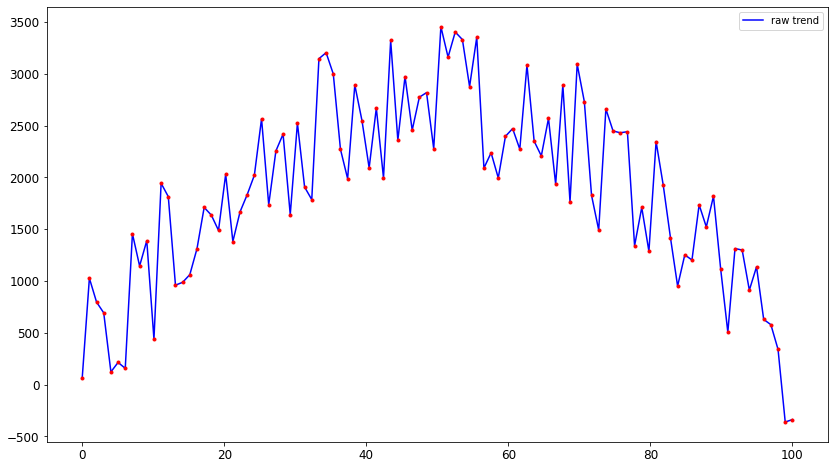

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Plot NOISY temp data
np.random.seed(42)
m = 100
X = np.linspace(0,m,m)
y = (-(X-m/2)**2) + (2000) + (np.random.rand(m)*m*15)
plt.figure(figsize=(14,8))
plt.plot(X, y,"b-", label = "raw trend")
plt.plot(X, y,"r.")
plt.legend()
plt.show()

For prediction purposes, or for simply more clear visualizations, we may want to smooth out this trend line. To do this, we can compute the **exponentially weighted averages** (ewa) as follows:

$$\mathbf{V_t}=\beta\cdot \mathbf{V_{t-1}} + (1-\beta)\cdot\theta_t$$

where:
- $\mathbf{V_t}$ represents the exponentially weighted average at timestep $t$
- $\beta$ acts as a smoothing parameter, and effectively determines over how many timesteps we'd like to average our values
- $\theta_t$ is the raw output value at timestep $t$ (e.g. temperature)

It can be shown mathematically that for any value of $\beta$, you will be effectively averaging your values over *approximately* $\frac{1}{1-\beta}$ timesteps. For example:
- $\beta$ = 0.9 will average last 10 entries
- $\beta$ = 0.98 will average last 50 entries
- $\beta$ = 0.5 will average last 2 entries

Let's implement this function with our temperature data and see what it looks like. Note that we have also divided each weighted average value by a **bias correction** term of $(1-\beta^t)$. This helps adjust the values at earlier timesteps as $\mathbf{V_0}=0$, and thus the bias of the weighted averages is shifted (in this case, downwards). Feel free to play around with the parameters, turning the bias correction term on and off, to see how the results are adjusted:

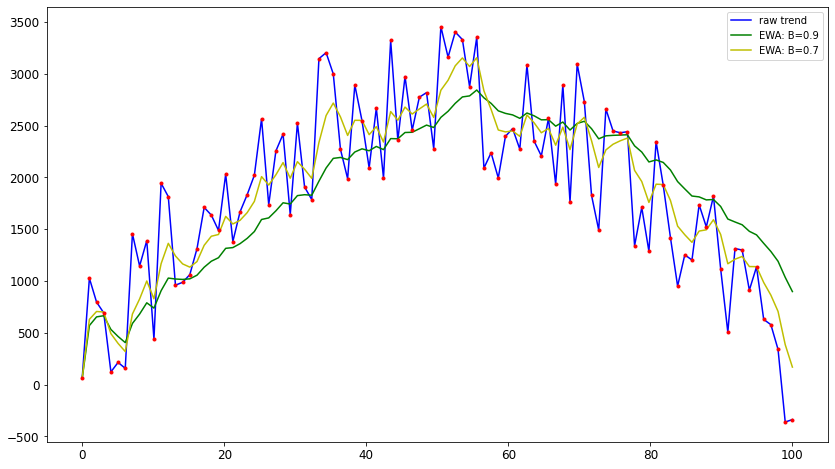

In [ ]:
# Create ewa function
def EWA(Y, beta, correct_bias=True):
    updates = []
    v=0
    for t,y in enumerate(Y):
        v = beta*v + (1-beta)*y
        v_bias = v/(1-beta**(t+1)) # Bias correction
        updates.append(v_bias if correct_bias else v)
    return updates

# Plot noisey data and smoothed data
np.random.seed(42)
m = 100
X = np.linspace(0,m,m)
y = (-(X-m/2)**2) + (2000) + (np.random.rand(m)*m*15)
plt.figure(figsize=(14,8))
plt.plot(X, y,"b-", label = "raw trend")
plt.plot(X, EWA(y,0.9), "g-", label = "EWA: B=0.9")
plt.plot(X, EWA(y,0.7), "y-", label = "EWA: B=0.7")

plt.plot(X, y,"r.")
plt.legend()

Look at that beautiful smooth trend line! Now that we understand exponentially weighted averages, let's see how they are applied to optimization methods.

## Momentum optimization



Imagine a bowling ball rolling down a gentle slope on a smooth surface: it will start out slowly, but it will quickly pick up momentum until it eventually reaches terminal velocity (if there is some friction or air resistance). This is the very simple idea behind **momentum optimization**.

Recall that Gradient Descent simply updates the weights $\theta$ by directly subtracting the **gradient of the cost function with respect to the weights** $\triangledown_\theta J(\theta)$ multiplied by the learning rate $\eta$.
- The equation is: $\theta \leftarrow \theta – \eta \triangledown_\theta J(\theta)$, and it does **not take into consideration the values of earlier gradients**.
- If the local gradient is tiny, training goes very slowly.

In contrast, momentum optimization takes previous gradients into consideration by calculating the **exponentially weighted average** (called the momentum vector) as it backpropagates through the layers. Mathematically, this can be presented as follows:

**1. Update momentum vector ($\mathbf{m}$):**

- $\mathbf{m_t}=\beta\cdot\mathbf{m_{t-1}} + (1-\beta)\cdot \triangledown_\theta J(\theta_t)$

**2. Update weights ($\theta$):**

- $\theta_t=\theta_{t-1} - \eta\cdot\mathbf{m_t}$

Where:
- $\eta$ is the learning rate
- $\triangledown_\theta J(\theta)$ is the gradient of the cost function with resepect to $\theta$
- $\beta$ is the momentum hyperparameter, which effectively determines **how many of the previous iterations' gradients to take into consideration.** It must be set between 0 (high friction) and 1 (no friction). A typical momentum value is 0.9. You can easily see that if momentum is set to zero, then we have plain old gradient descent.
- $\mathbf{m}$ is the momentum vector

Note that in practice, people don't bother implementing **bias correction** with momentum. Here is pseudo code:

```python
beta = 0.9
lr=0.01
for _ in num_iterations:
    dw = compute_gradients(x, y) # calculate gradients
    momentum = beta * momentum + (1-beta) * dw # update momentum vector
    w = w - lr * momentum # update weights
```

So why does momentum tend to work better than plain old gradient descent?
- With Stochastic Gradient Descent (SGD), we are computing the gradient of the loss function over sub samples of the training data (mini-batches). This means that we are going to see **a lot of volatility with our weight updates, and we will not always be pushing the parameters in the optimal direction**.
    - In essence, the gradients are 'noisy', just like the temperature data above.
-That said, **exponentially weighed averages can provide us a better estimate of the derivate of the full training set than our noisy mini-batch calculations.**

The other reason lies in **ravines:**
- A ravine is an area of a parabola where the **surface curves much more steeply in one dimension than in another.**
- We want to get down to the minima, but for that we have to move through the ravine. This region is what is called **pathological curvature:**

<img src="https://drive.google.com/uc?id=1ee3wZiX-cpDFgSpYYYcU2GzR-tILfIBH" style="width:450px;height:250px;">

It's not very hard to get the hang of what is going on in here:
- Gradient descent is **bouncing along the ridges of the ravine**, and moving a lot slower towards the minima. This is because the surface at the ridge curves much more steeply in the direction of w1.
- Ravines are common near local minimas in deep learning and SGD has troubles navigating them.
- SGD will tend to oscillate across the narrow ravine since the negative gradient will point down one of the steep sides rather than along the ravine towards the optimum.

With momentum optimization, **the momentum term increases for dimensions whose gradients point in the same directions** and **reduces updates for dimensions whose gradients change directions**, thus accumulating "momentum" on the optimal path along the ravine. This allows momentum optimization to escape from plateaus much faster than Gradient Descent. This is illustrated in the image below:  

<img src="https://drive.google.com/uc?id=1TkwFOg4B_48j3g0Jg66WYbNvrHgmeGf_" style="width:700px;height:250px;">


**NOTE:** Due to the momentum, the optimizer may overshoot a bit, then come back, overshoot again, and oscillate like this many times before stabilizing at the minimum. This is one of the reasons why it is good to have a bit of friction in the system (a $\beta$ value of around 0.9): it gets rid of these oscillations and thus speeds up convergence.


We can implement momentum optimization by changing the optimizer argument in our `model.compile` function as follows:


In [ ]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)



**NOTE:** we have set the `nesterov` argument to `True`. This implements the **Nesterov Accelerated Gradient (NAG)** method, which simply measures the gradient of the cost function not at the local position, but slightly ahead in the direction of the momentum. The only difference is that the gradient is measured at $\theta+\beta\mathbf{m}$ instead of $\theta$.
- This small tweak works because in general **the momentum vector will be pointing in the right direction** (i.e., toward the optimum), so it will be slightly more accurate to use the gradient measured a bit further in that direction rather than using the gradient at the original position.
- In general, **NAG ends up being significantly faster than regular momentum optimization.**



## AdaGrad



The AdaGrad optimizer is similar to the momentum algorithm, in that it tends to find a more direct path to the global minimum as compared to "vanilla" or plain old gradient descent. However, it does so by trying to solve the problem of **widely varying gradient magnitudes**.
- Some gradients may be tiny and others may be huge, which can result in a very difficult problem trying to find a **single global learning rate for the algorithm.**

This is sometimes called the elongated bowl problem:
- **Gradient descent starts by quickly going down the steepest slope, then slowly goes down the bottom of the valley.**
- It's worth noting that **we can’t simply solve this problem by increasing the learning rate**.
    - The steps we take with large gradients will be even bigger, which may result in divergence.

The AdaGrad algorithm attempts to solve this problem by **scaling down the gradient vector along the steepest dimension, and increasing the gradient vectors along the flattest dimensions.**

To do this, AdaGrad first accumulates the squared gradients into vector $\mathbf{s}$. **The algorithm then uses the root of this vector to scale the update vector** ($\eta\cdot\triangledown_\theta J(\theta_t)$. If the cost function is steep along the $i^{th}$ dimension, then $\mathbf{s^i}$ will get larger and larger at each iteration. This process can be represented mathematically as follows:

**1. Accumulate squared gradient vector ($\mathbf{s}$):**

- $\mathbf{s_t}=\mathbf{s_{t-1}} + (\triangledown_\theta J(\theta_t))^2$

**2. Update weights ($\theta$):**

- $\theta_t=\theta_{t-1} - \eta \cdot\triangledown_\theta J(\theta_t) \oslash \sqrt{s_t+\epsilon}$

The notation is similar to that of the momentum equations above, however here we are **not** taking a moving average:
- We are simply accumulating squared gradient values,
- And we are **dividing the learning rate by the $\sqrt{\mathbf{s_t}}$ (this is what adjusts the value of the updates based on the previous gradients size or steepness).** You can think of this as an **Adaptive Learning Rate**.
- Note that in order to ensure that we are not dividing by zero, we add a small value $\epsilon$ (e.g. `epsilon = 10^-8`) to $\mathbf{s_t}$.

For additional clarity, the process can be represented in pseudo code as follows:

```python
grads_squared = 0
lr=0.01
epsilon = 1e-08
for _ in num_iterations:
    dw = compute_gradients(x, y)
    grads_squared += grads_squared + dw * dw # element wise multiplication (squaring gradients)
    w = w - (lr / np.sqrt(grads_squared+epslion)) * dw
```

As you can tell, the algorithm is almost identical to Gradient Descent, but with one big difference:
- **the gradient vector is scaled down by a factor of `np.sqrt(s+ϵ)`.**  
- This algorithm **decays the learning rate, but it does so faster for steep dimensions than for dimensions with gentler slopes.**
- This is called an **adaptive learning rate.** It helps point the resulting updates more directly toward the global optimum.
- One additional benefit is that it requires much less tuning of the learning rate hyperparameter $\eta$.


<img src="https://drive.google.com/uc?id=1iJMsIjUnzaXUkh5GvU8Ya_u06T_OaMMX" style="width:500px;">


We can implement AdaGrad optimization simply by changing the optimizer argument in our `model.compile` function as follows:

In [ ]:
optimizer = keras.optimizers.Adagrad(lr=0.001)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


AdaGrad frequently performs well for simple quadratic problems, but **it often stops too early when training neural networks.**
- The learning rate gets scaled down so much that the algorithm ends up stopping entirely before reaching the global optimum.

## RMSProp


Although AdaGrad slows down a bit too soon and ends up never converging to the global optimum, the RMSProp algorithm fixes this by **accumulating only the gradients from the most recent iterations** (as opposed to all the gradients from the beginning of training).
- RMSprop takes the *exponentially weighted average* of the squared gradients at every step (the RMS in RMSprop stands for *root mean squared*).
- This is the same as the momentum vector, but we are simply squaring the gradients.
- We then use the root of this vector to scale the update vector ($\eta\cdot\triangledown_\theta J(\theta_t)$, just as we did with AdaGrad.

This can be represented mathematically as follows:

**1. Update squared gradient vector ($\mathbf{m}$):**

- $\mathbf{s_t}=\beta\cdot\mathbf{s_{t-1}} + (1-\beta)\cdot (\triangledown_\theta J(\theta_t))^2$

**2. Update weights ($\theta$):**

- $\theta_t=\theta_{t-1} - \eta \cdot\triangledown_\theta J(\theta_t) \oslash \sqrt{s_t+\epsilon}$

The notation is similar to that of the momentum equations, we have just squared the gradients in the first equation, and replaced the momentum vector $\mathbf{m}$ with the squared gradient vector $\mathbf{s}$. For additional clarity, the process can be represented in pseudo code as follows:
```python
grads_squared = 0
beta = 0.9
lr=0.01
epsilon = 1e-08
for _ in num_iterations:
    dw = compute_gradients(x, y)
    grads_squared = beta * grads_squared + (1-beta) * dw * dw # element wise multiplication (squaring gradients)
    w = w - (lr / np.sqrt(grads_squared+epslion)) * dw
```
Just as we did with AdaGrad, what we are effectively doing here is:
- *increasing* the updates for small gradients
- *decreasing* the updates for large gradients

The key difference with RMSProp however is that we use the exponential average so that our gradients don't increase or decrease too quickly. **This adjustment helps a great deal with saddle points and plateaus.**

We can implement RMSprop optimization simply by changing the optimizer argument in our `model.compile` function as follows:

In [ ]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In  the `RMSprop` function, `rho` represents the exponentially weighted average decay factor ($\beta$).

## Adam Optimization



Adam, which stands for **adaptive moment estimation**, combines the ideas of **Momentum optimization and RMSProp:**
- just like Momentum optimization it keeps track of an exponentially decaying average of past gradients,
- and just like RMSProp it keeps track of an exponentially decaying average of past *squared* gradients.

Since Adam is an adaptive learning rate algorithm (like RMSProp and AdaGrad), it requires **less tuning of the learning rate** hyperparameter $\eta$. You can often use the default value $\eta = 0.001$, making Adam even easier to use than Gradient Descent.

The algorithm can be represented mathematically as follows:


**1. Update momentum ($\mathbf{m}$) and squared gradients vectors ($\mathbf{s}$) :**

- $\mathbf{m_t}=\beta_1\cdot\mathbf{m_{t-1}} + (1-\beta_1)\cdot \triangledown_\theta J(\theta_t)$

- $\mathbf{s_t}=\beta_2\cdot\mathbf{s_{t-1}} + (1-\beta_2)\cdot (\triangledown_\theta J(\theta_t))^2$

**2. Adjust bias:**


- $\mathbf{m_t} = \frac{\mathbf{m_t}}{1-\beta_1^t}$
- $\mathbf{s_t} = \frac{\mathbf{s_t}}{1-\beta_2^t}$

**2. Update weights ($\theta$):**

- $\theta_t=\theta_{t-1} - \eta \cdot\mathbf{m_t} \oslash \sqrt{s_t+\epsilon}$

Again, the parameters are very similar to what we saw with momentum and RMSprop, however we have added $\beta_1$ and $\beta_2$, as we apply separate decay factors to each component.
- The momentum decay hyperparameter $\beta_1$ is typically initialized to 0.9,
- the scaling decay hyperparameter $\beta_2$ is often initialized to 0.999.

The smoothing term ϵ is usually initialized to a tiny number such as 10e–8. We also adjust the $\mathbf{m_t}$ and $\mathbf{s_t}$ for bias (as explained in the exponentially weighted average section above), which is commonly done with Adam.

Here is the pseudo code:

```python
grads_squared = 0
beta1 = 0.9
beta2 = 0.99
lr=0.01
epsilon = 1e-08
for i in range(1, num_iterations+1):
    # Caclulate gradient
    dw = compute_gradients(x, y)
    # Calculate momentum and RMSprop averages
    grads_momentum = beta1 * grads_momentum + (1-beta1) * dw
    grads_squared = beta2 * grads_squared + (1-beta2) * dw * dw
    # Fix bias
    grads_momentum = grads_momentum / (1 - beta1**i)
    grads_squared = grads_squared / (1 - beta2**i
    # Make updates
    w = w - (lr / np.sqrt(grads_squared+epslion)) * grads_momentum # Make updates
```

We can implement momentum optimization simply by changing the optimizer argument in our `model.compile` function as follows:

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Since Adam is an **adaptive learning rate algorithm (like AdaGrad and RMSProp),** it requires less tuning of the learning rate hyperparameter $\eta$.
- You can often use the default value η = 0.001, making Adam even easier to use than Gradient Descent.

For more information on Adam, check out this excellent blog post: https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c

## Adamax



Notice that in step 2 of Adam equations above, the algo accumulates the squares of the gradients in $s$ (with a greater weight for more recent weights). Then Adam scales down the parameter updates by the square root of $s$.
- In short, Adam scales down the parameter updates by the $\iota_2$ norm of the time-decayed gradients **(recall that the ℓ2 norm is the square root of the sum of squares).**
- AdaMax, introduced in the same paper as Adam, replaces the ℓ2 norm with the ℓ ∞ norm (a fancy way of saying the max).
- Specifically, it replaces the ℓ2 norm with $\mathbf{s_t}=max(\beta_2\mathbf{s_{t-1}}, \triangledown_\theta J(\theta_t))$, and it scales down the gradient updates by a factor of $s$ , which is just **the max of the time-decayed gradients**.

In practice, this can make AdaMax more stable than Adam, but it really depends on the dataset, and **in general Adam performs better**. So, this is just one more optimizer you can try if you experience problems with Adam on some task.


In [ ]:
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


## Nadam



Nadam optimization is Adam optimization **plus the Nesterov trick**, so it will often converge slightly faster than Adam.

In his report introducing this technique , the researcher Timothy Dozat compares many different optimizers on various tasks and finds that Nadam generally outperforms Adam but is sometimes outperformed by RMSProp.

In [ ]:
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


## Choosing an optimizer

The following table compares all the optimizers we’ve discussed so far (* is bad, ** is average, and *** is good):

<img src="https://drive.google.com/uc?id=1Jlm4yGAUHNfIIv0bgLPfee_VfvHploE4" style="width:600px">


In [ ]:
X_train, X_valid, X_test, y_train, y_valid, y_test = mnist_fashion_clean()

X_trian: (55000, 28, 28)
X_valid: (5000, 28, 28)
X_test: (10000, 28, 28)
X_train stats: 0.28603044 0.35290107
X_valid stats: 0.2861465 0.35437852
X_test stats: 0.28684944 0.3524442


Running VanillaSGD model...
Training complete in 5.53 seconds
Running Momentum model...
Training complete in 5.55 seconds
Running AdaGrad model...
Training complete in 5.52 seconds
Running RMS model...
Training complete in 4.86 seconds
Running Adam model...
Training complete in 5.57 seconds


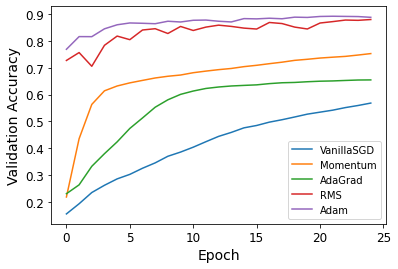

In [ ]:
# let's compare these different optimizers and see what we get!

"""NOTE: running all models should take 2-3 minutes."""
from time import time

# Build simple sequence model
def build_model():
    return keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
#         keras.layers.BatchNormalization(),
        keras.layers.Dense(300, activation="relu", kernel_initializer='random_normal'),
#         keras.layers.BatchNormalization(),
        keras.layers.Dense(100, activation="relu", kernel_initializer='random_normal'),
#         keras.layers.BatchNormalization(),
        keras.layers.Dense(10, activation="softmax")
    ])

# Set optimizers
op0 = tf.keras.optimizers.SGD(lr=0.001) # Standard SGD
op1 = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)
op2 = tf.keras.optimizers.Adagrad(lr=0.001)
op3 = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-8)
op4 = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Run models
results = {}
for optimizer, name in [(op0, 'VanillaSGD'), (op1, 'Momentum'),(op2,'AdaGrad'), (op3, 'RMS'),(op4, "Adam")]:
    print("Running {} model...".format(name))
    model = build_model()
    t0 = time()
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    out = model.fit(X_train, y_train, epochs=25, batch_size=3200, validation_data=(X_valid, y_valid), verbose=0) #turn off verbosity
    print("Training complete in {:.2f} seconds".format(time()-t0))
    results[name] = out.history['val_accuracy']
    plt.plot(out.history['val_accuracy'], label=name)

plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Exercise: Adam Optimizer
Try running Momentum, RMSprop, and Adam for a 20 to 30 epochs. Do you see a different in the accuracy at a certain point?

In [ ]:
# Initialize simple_model function
def simple_model_bn(initializer='he_normal', activation='relu'): # Use relu as base activation function
    return tf.keras.Sequential([layers.Flatten(input_shape=(28,28,)),
                                layers.Dense(32, activation=None, kernel_initializer=initializer),
                                layers.BatchNormalization(trainable=True, scale=True, center=True), # Add BatchNorm
                                layers.Activation(activation), # Add relu activation layer
                                layers.Dense(32, activation=None, kernel_initializer=initializer),
                                layers.BatchNormalization(trainable=True, scale=True, center=True), # Add BatchNorm
                                layers.Activation(activation), # Add relu activation layer
                                layers.Dense(32, activation=None, kernel_initializer=initializer),
                                layers.BatchNormalization(trainable=True, scale=True, center=True), # Add BatchNorm
                                layers.Activation(activation), # Add relu activation layer
                                layers.Dense(32, activation=None, kernel_initializer=initializer),
                                layers.BatchNormalization(trainable=True, scale=True, center=True), # Add BatchNorm
                                layers.Activation(activation), # Add relu activation layer
                                layers.Dense(10, activation='softmax', kernel_initializer=tf.keras.initializers.glorot_normal())])
print("Model WITH BatchNorm")
simple_model_bn().summary()

Model WITH BatchNorm
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_70 (Flatten)        (None, 784)               0         
                                                                 
 dense_580 (Dense)           (None, 32)                25120     
                                                                 
 batch_normalization_6 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 32)                0         
                                                                 
 dense_581 (Dense)           (None, 32)                1056      
                                                                 
 batch_normalization_7 (Batc  (None, 32)               128       
 hNormalization)                

Running VanillaSGD model...
Running Momentum model...
Running AdaGrad model...
Running RMS model...
Running Adam model...


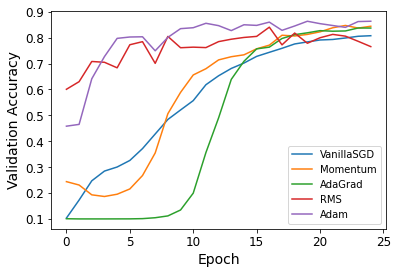

CPU times: user 44.4 s, sys: 1.99 s, total: 46.4 s
Wall time: 45 s


In [ ]:
%%time
"""NOTE: running all models should take 2-3 minutes."""

# Set params
init = tf.keras.initializers.random_normal()
activate = 'relu'

# Set optimizers
op0 = tf.keras.optimizers.SGD(lr=0.01) # Standard SGD
op1 = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
op2 = tf.keras.optimizers.Adagrad(lr=0.01)
op3 = tf.keras.optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-8)
op4 = tf.keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999)

# Run models
results = {}
for optimizer, name in [(op0, 'VanillaSGD'), (op1, 'Momentum'),(op2,'AdaGrad'), (op3, 'RMS'),(op4, "Adam")]:
    print("Running {} model...".format(name))
    model = simple_model_bn(init, activate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    out = model.fit(X_train, y_train, epochs=25, batch_size=3200, validation_data=(X_test, y_test), verbose=0) #turn off verbosity
    results[name] = out.history['val_accuracy']
    plt.plot(out.history['val_accuracy'], label=name)

plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

As we can see from the above exercise, Adam seems to converge faster than the AdaGrad and RMS prop. While your results will always depend on the type of model you are building, as well as the data itself, in general **Adam will more quickly and efficiently find the global minimum of your loss function.**

## Learning Rate Scheduling

Now that we have a solid handle on deep learning optimizers and how to implement them, we are going to discuss one final topic to help you refine model training: **learning rate scheduling.**

Finding a good learning rate can be tricky:
- If you set it way too high, training may actually diverge
- If you set it too low, training will eventually converge to the optimum, but it will take a very long time.
- If you set it slightly too high, it will make progress very quickly at first, but it will end up dancing around the optimum, never settling down (unless you use an adaptive learning rate optimization algorithm such as AdaGrad, RMSProp, or Adam, but even then it may take time to settle). **If you have a limited computing budget, you may have to interrupt training before it has converged properly, yielding a suboptimal solution.**


<img src="https://drive.google.com/uc?id=1sX6qriDfcLBJjIw85EuWgDEb53vY1gFI">

Image source: University of Waterloo

Image description: Model training performance based on different learning rate schedules. Note that this is a generalization, and your results will always depend on the data and model architecture.

The ideal learning rate will learn quickly and converge to good solution. However, you can do better than a constant learning rate: **if you start with a high learning rate and then reduce it once it stops making fast progress, you can reach a good solution faster than with the optimal constant learning rate.**



There are many different strategies to reduce the learning rate during training. **These strategies are called learning schedules**, the most common of which are:

- **Exponential scheduling:**
  - Set the learning rate to a function of the iteration number $t: \eta_t = \eta_0 \cdot 0.1^{\frac{t}{s}}$.
    - This works great, but it requires tuning $\eta_0$ and $s$. The learning rate will drop by a factor of 10 every s steps.


- **Power scheduling:**
    - Set the learning rate to a function of the iteration number $t: \eta_t = \eta_0 / (1+\frac{t}{s})^{c}$
    - $η_0$ is the initial learning rate and $s$ represents the number of steps. The hyperparameter $c$ is typically set to 1.
    - The learning rate drops at each step. After $s$ steps, it is down to $η_0 / 2$. After $s$ more steps, it is down to $η_0 / 3$, then it goes down to $η_0 / 4$, then $η_0 / 5$, and so on.
    - As you can see, this schedule first drops quickly, then more and more slowly. Of course, power scheduling requires tuning $η_0$ and $s$ (and possibly $c$ ).
    
    
- **Piecewise constant learning rate:**
    - The learning rate reduces based on predefined update steps. For example, set the learning rate to $\eta_0 = 0.01$ at first, then to $\eta_1 = 0.001$ after 50 epochs.
    - Although this solution can work very well, it often requires fiddling around to figure out the right learning rates and when to use them.


- **Performance scheduling:**
    - Measure the validation error every N steps and reduce the learning rate by a factor of $\lambda$ when the error stops dropping.


- **1cycle scheduling:**
    - Contrary to the other approaches, 1cycle (introduced in a 2018 paper by Leslie Smith) starts by increasing the initial learning rate $η_0$ , growing linearly up to $η_1$ halfway through training.
    - Then it decreases the learning rate linearly down to $η_0$ again during the second half of training, finishing the last few epochs by dropping the rate down by several orders of magnitude (still linearly).
    - The maximum learning rate $η_1$ is chosen using the same approach we used to find the optimal learning rate, and the initial learning rate $η_0$ is chosen to be roughly 10 times lower.
    - When using a momentum, we start with a high momentum first (e.g., 0.95), then drop it down to a lower momentum during the first half of training (e.g., down to 0.85, linearly), and then bring it back up to the maximum value (e.g., 0.95) during the second half of training, finishing the last few epochs with that maximum value.
    - Smith did many experiments showing that this approach was often able to speed up training considerably and reach better performance. For example, on the popular CIFAR10 image dataset, this approach reached 91.9% validation accuracy in just 100 epochs, instead of 90.3% accuracy in 800 epochs through a standard approach (with the same neural network architecture ).


A 2013 paper by Andrew Senior et al. compared the performance of some of the most popular learning schedules when training deep neural networks for speech recognition using Momentum optimization. The authors concluded that, in this setting, both performance scheduling and exponential scheduling performed well, **but they favored exponential scheduling because it is simpler to implement, is easy to tune, and converged slightly faster to the optimal solution.**

## Exponential Scheduling


Exponential scheduling and piecewise scheduling are quite simple too:
- You first need to define a function that takes the **current epoch and returns the learning rate.**

```lr = lr0 * 0.1**(epoch / s)```

In [ ]:
n_epochs=50

In [ ]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

If you do not want to hardcode η 0 and s , you can create a function that returns a **configured function**:

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

Next, create a `LearningRateScheduler` callback, giving it the schedule function, and pass this callback to the `fit()` method. The `LearningRateScheduler` will update the optimizer’s `learning_rate` attribute at the **beginning of each epoch**.



In [ ]:
# Pass this into model.compile in the callbacks arg
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

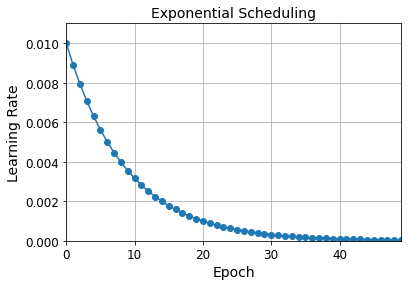

In [ ]:
epochs = np.arange(n_epochs)
lrs = exponential_decay_fn(epochs)

plt.plot(epochs, lrs, "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

In [ ]:
# building a custom callback for iteration-based scheduling
# (as opposed to the built-in epoch-based scheduling)
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [ ]:
# in the code below, we build and train a model using
# exponential learning rate scheduling

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6981 - accuracy: 0.7741 - val_loss: 0.8349 - val_accuracy: 0.7454 - lr: 0.0089
Epoch 2/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5140 - accuracy: 0.8252 - val_loss: 0.4198 - val_accuracy: 0.8584 - lr: 0.0079
Epoch 3/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4436 - accuracy: 0.8471 - val_loss: 0.5615 - val_accuracy: 0.8248 - lr: 0.0071
Epoch 4/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4077 - accuracy: 0.8598 - val_loss: 0.3829 - val_accuracy: 0.8754 - lr: 0.0063
Epoch 5/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3778 - accuracy: 0.8701 - val_loss: 0.3902 - val_accuracy: 0.8664 - lr: 0.0056
Epoch 6/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3512 - accuracy: 0.8793 - val_loss: 0.3528 - val_accuracy: 0.8814 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 9s

In [ ]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

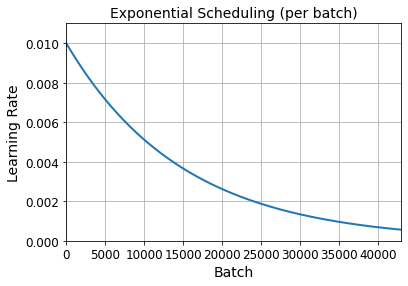

In [ ]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

Aslo we can use `Keras Scheduler` for implementing `Exponential Scheduling`.

In [ ]:
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



In [ ]:
history = model.fit(X_train, y_train, epochs=n_epochs,validation_data=(X_valid, y_valid))

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5822 - accuracy: 0.7947 - val_loss: 0.5993 - val_accuracy: 0.7804
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4264 - accuracy: 0.8420 - val_loss: 0.3810 - val_accuracy: 0.8622
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3857 - accuracy: 0.8587 - val_loss: 0.5424 - val_accuracy: 0.7994
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3638 - accuracy: 0.8665 - val_loss: 0.3512 - val_accuracy: 0.8722
Epoch 5/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3461 - accuracy: 0.8726 - val_loss: 0.3458 - val_accuracy: 0.8702
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3284 - accuracy: 0.8791 - val_loss: 0.3616 - val_accuracy: 0.8754
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3188 - accuracy: 0.8823 - val_loss: 0.3511 - val_accuracy:

# Avoiding Overfitting through Regularization

Deep neural networks typically have tens of thousands of parameters, sometimes even millions. This gives them an incredible amount of freedom and means they can fit a huge variety of complex datasets. But this great flexibility also makes the network prone to overfitting the training set. **We need regularization**.

In this section we will examine popular regularization techniques for neural networks:
- early stopping
- ℓ 1 and ℓ 2 regularization,
- dropout,
- and max-norm regularization.



## Early Stopping
A problem with training neural networks is in the choice of the number of training epochs to use. Too many epochs can lead to overfitting of the training dataset, whereas too few may result in an underfit model. Early stopping is a method that allows you to specify an arbitrary large number of training epochs and stop training once the model performance stops improving on a hold out validation dataset.

Keras supports the early stopping of training via a callback called `EarlyStopping`. This callback allows you to **specify the performance measure to monitor and the trigger that will stop the training process.** Let's take a quick look at the initialization (init) signature:
```python
from tensorflow.keras.callbacks import EarlyStopping
EarlyStopping(monitor='val_loss',
              min_delta=0,
              patience=0,
              verbose=0,
              mode='auto',
              baseline=None,
              restore_best_weights=False)
```
Let's dig into these arguments:
- `monitor`: Select the metric or quantity to be monitored.
- `min_delta`: Minimum change in the monitored quantity to qualify as an improvement (i.e., an absolute change of less than `min_delta`, will count as no improvement)
- `patience`: Number of epochs with no improvement after which training will be stopped.
- `verbose`: verbosity mode; to discover the training epoch on which training was stopped, set this argument to 1.
- `mode`: One of `{"auto", "min", "max"}`. In `min` mode, training will stop when the quantity monitored has stopped decreasing; in `max` mode it will stop when the quantity monitored has stopped increasing; in `auto` mode, the direction is automatically inferred from the name of the monitored quantity.
- `baseline`: Baseline value for the monitored quantity. Training will stop if the model doesn't show improvement over the baseline.
- `restore_best_weights`: Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used.

Most of these arguments are self-explanatory, so lets try incorporating EarlyStopping into a model. We will use the `make_moons` dataset with extra noise and only 100 samples so it is easy to overfit (for demonstration purposes). Take a look at the data below:

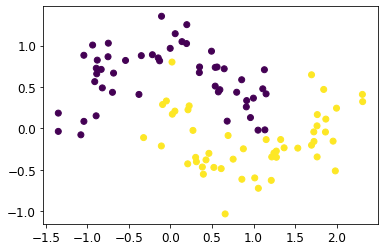

X_train: (50, 2)
y_train: (50,)
X_test: (50, 2)
y_test: (50,)


In [ ]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

# Generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=1)
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

# split into train and test
n_train = 50
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

# Check shapes
print('X_train:',X_train.shape)
print('y_train:',y_train.shape)
print('X_test:',X_test.shape)
print('y_test:',y_test.shape)

In [ ]:
# Import tf and keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Train: 1.000, Test: 0.920


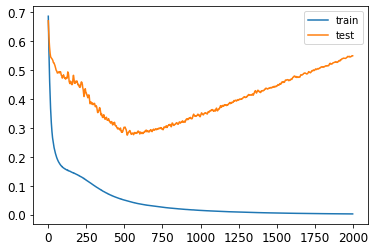

CPU times: user 54.8 s, sys: 4.66 s, total: 59.4 s
Wall time: 53.6 s


In [ ]:
%%time
# Note this code block should take around 1 minute to run

# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2000, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

We can see that  our model reaches a global minimum on test loss at around **600 epochs**, after which it begins to overfit the test data. As such, let's implement early stopping and run this again! We will monitor the `val_loss` with a `patience` value of 200 epochs, and set `restore_best_weights` to `True`:

In [ ]:
# Import EarlyStopping function
from tensorflow.keras.callbacks import EarlyStopping

Restoring model weights from the end of the best epoch: 561.
Epoch 761: early stopping
Train: 1.000, Test: 0.920


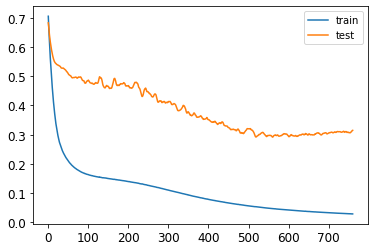

CPU times: user 22.2 s, sys: 1.93 s, total: 24.2 s
Wall time: 21.3 s


In [ ]:
%%time
# Note this code block should take around 1 minute to run

# Reset the model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Add early stopping
es = EarlyStopping(monitor='val_loss', mode='min', patience=200, restore_best_weights=True, verbose=1)

# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2000, callbacks=[es], verbose=0)

# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

Note that because we had the `restore_best_weights` argument in our callback set to true, our model automatically reverts to the best performing weights. That said, if you are training your model for many hours and want to automatically save the best model when a global minimum is reached, you can do so by adding a `ModelCheckpoint` callback into the fit function:
```python
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
```
The code is very simple (and similar to the EarlyStopping callback), so we won't dig into it anymore here. However, feel free to apply it to your own models, especially if you are planning on training a very large model for many hours.

<a id="L1_and_L2_Regularization"></a>
## L1 and L2 Regularization

Although early stopping works very well in practice, you can usually get much higher performance out of your network by combining it with other regularization techniques; **the most common of these techniques is L1/L2 regularization.** You have covered L1 and L2 regularization in the pre-requisite ML course, so we won't go into details here. The main difference when applying regularization to neural nets (as opposed to a simple linear regression, for example) is that you apply L1 and L2 to each layer individually.

The `tf.keras.regularizers` module and the `activity_regularizer` argument in most `tf.keras.layer` classes makes applying regularization to individual layers very easy. `tf.keras.regularizers` supports three different regularization techniques, each provided as a class:
- `l1`: Activity is calculated as the sum of absolute values.
- `l2`: Activity is calculated as the sum of the squared values.
- `l1_l2`: Activity is calculated as the sum of absolute and sum of the squared values.

Each of the `l1` and `l2` regularizers takes a single hyperparameter that controls the amount that each activity contributes to the sum. The l1_l2 regularizer takes two hyperparameters, one for each of the L1 and L2 methods:

```python
# import regularizers
from tensorflow.keras.regularizers import l1, l2, l1_l2
# instantiate regularizers
reg_l1 = l1(0.001)
reg_l2 = l1(0.001)
reg_l1l2 = l1_l2(0.001, 0.001)
```
To add the above regularizers to you models, you have two options:

1. Apply regularization PRE activation
```python
...
model.add(Dense(32, activation=None, activity_regularizer=l1(0.001)))
model.add(Activation('relu')
...
```
1. Apply regularization POST activation
```python
...
model.add(Dense(32, activation='relu', activity_regularizer=l1(0.001)))
...
```

**PRE activation is probably the preferred usage of activation regularization**, for the model to learn to take activations to a true zero value in conjunction with the rectified linear activation function. Nevertheless, you should test out both methods to see which one works best with your model architecture and dataset.

Let's test out these regularizers on the 'make_circles' dataset below. Just as we did in the EarlyStopping example, we will use a small sample size (100 observations with a 30/70 split) so that the model is likely to overfit the data. Hopefully our L1/L2 regularizers will step in to save the day!

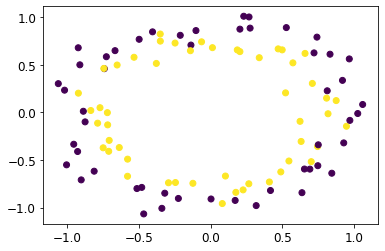

X_train: (30, 2)
y_train: (30,)
X_test: (70, 2)
y_test: (70,)


In [ ]:
from sklearn.datasets import make_circles

# Generate 2d classification dataset
X, y = make_circles(n_samples=100, noise=0.1, random_state=1)
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

# split into train and test
n_train = 30
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

# Check shapes
print('X_train:',X_train.shape)
print('y_train:',y_train.shape)
print('X_test:',X_test.shape)
print('y_test:',y_test.shape)

Model without Regularization:

Train: 1.000, Test: 0.771


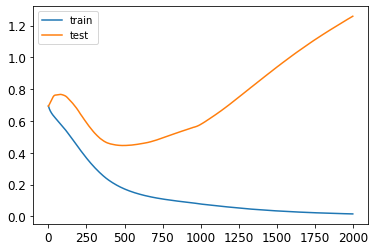

CPU times: user 51.3 s, sys: 4.41 s, total: 55.7 s
Wall time: 50.8 s


In [ ]:
%%time
# Note this code block should take around 1 minute to run

# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2000, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Once again, we the see the model is overfitting the training data. Lets add regularization and see if it makes a difference; we will use l1_l2 below, but as always you are encouraged to try out multiple approaches to find one that best fits your data and objectives.

In [ ]:
# Import regularizers and activation layer
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.layers import Activation

Model with both L1 and L2 regularization

Train: 0.967, Test: 0.786


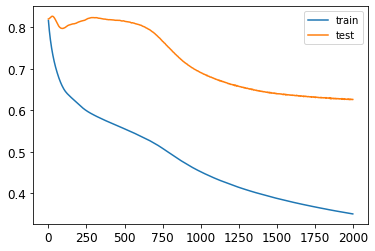

CPU times: user 52.6 s, sys: 4.66 s, total: 57.2 s
Wall time: 1min 22s


In [ ]:
%%time
# Note this code block should take around 1 minute to run

reg_l1l2 = l1_l2(0.005, 0.005)

# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation=None, activity_regularizer=reg_l1l2))
model.add(Activation('relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2000, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Not bad! The l1_l2 regularization seems to prevent model from overfitting, and the test accuracy values seem to level off at about epoch 1000. Again, we decided to use l1_l2 regulatization, but every model and dataset is different so its up to you to experiment and find the right combination for your use case.

<a id="Dropout"></a>
## Dropout
The most popular regularization technique for deep learning is arguably **Dropout**, a method proposed by Geoffry Hinton in 2012 and further detailed in a paper by Nitish Srivastava in 2014. The technique has proven to improve accuracy for a wide variety of model architectures; even state-of-the-art neural networks often get a 1–2% accuracy boost simply by adding dropout. Despite this success, the algorithm itself is surprisingly simple:
- At every training step, every neuron (including the input neurons **but excluding the output neurons**) has a probability $p$ of being temporarily “dropped out,” meaning it will be ignored during this training step, but it may be active during the next step.
- The hyperparameter $p$ is called the dropout rate, and it is typically set to 50%. After training, neurons **do NOT get dropped anymore.**

<img src="https://drive.google.com/uc?id=1ZRnNkV1qSFvZPDW4ZDfXtjfvEoLw-DUr" style="width:600px;height:250px;">

Image source: University of Waterloo

Image Description: A basic representation of dropout regularization as applied to a standard feedforward neural network

The essential intuition here is that **neurons trained with dropout cannot co-adapt with their neighboring neurons; they have to be as useful as possible on their own.** They also cannot rely excessively on just a few input neurons; they must pay attention to each of their input neurons. They end up being less sensitive to slight changes in the inputs. In the end you get a more robust network that generalizes better.

Another way to understand the power of dropout is to realize that a unique neural network is generated at each training step. Since each neuron can be either present or absent, there is a total of $2^N$ possible networks (where $N$ is the total number of droppable neurons). This means that it is extremely unlikely that the same neural network will be sampled twice. Once you have run 10,000 training steps, you have essentially **trained 10,000 different neural networks** (each with just one training instance). These neural networks are obviously not independent as they share many of their weights, but they are nevertheless all different. The resulting neural network can be seen as an **averaging ensemble of all these smaller neural networks.**



**NOTE:** There is one small but important technical detail:
- Suppose the dropout rate $p = 50$. This means during testing, a neuron will be connected to twice as many input neurons as it was (on average) during training (remember - all neurons are used during testing)
- To compensate for this fact, we need to multiply each neuron’s input connection weights by 0.5 after training. If we don’t, each neuron will get a total input signal roughly twice as large as what the network was trained on, and it is unlikely to perform well.
- The general rule is: **multiply each input connection weight by the keep probability $(1-p)$ after training.**

We can implement dropout for each individual layer in keras using the `tf.keras.layers.Dropout` layer as follows:

```python
# example of dropout between fully connected layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
...
model.add(Dropout(rate=0.8, input_shape=(784,)))
model.add(Dense(32))
model.add(Dropout(rate=0.5))
model.add(Dense(1))
```

Note that we add a `Dropout` layer just as we would add another `Dense` or `Activation` layer, and we use the `rate` argument to specify the 'keep probability' $p$ (the probability a neuron will **remain on**). We also apply a 20% dropout rate (80% keep probability) to the input layer, by specifying `input_shape` in the first dropout layer.

Let's test out dropout! Here we will use the 3 dimensional 'make_s_curve' dataset:

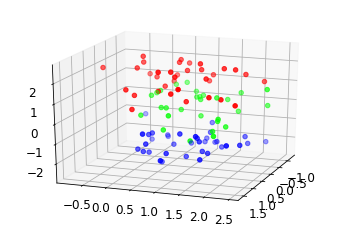

X_train: (30, 3)
y_train: (30, 3)
X_test: (70, 3)
y_test: (70, 3)


In [ ]:
from sklearn.datasets import make_s_curve
from tensorflow.keras.utils import to_categorical
from mpl_toolkits.mplot3d import axes3d, Axes3D
import pandas as pd

# Generate 2d classification dataset
X, y = make_s_curve(100, noise=0.3, random_state=1)
# Transform data to multi-class
y = pd.cut(y, bins=3, labels=[0,1,2])
y = to_categorical(y)

ax = plt.axes(projection='3d')
ax.scatter3D(X[:,0], X[:,1], X[:,2], c=y, cmap='Greens');
ax.view_init(20,20)
plt.show()

# split into train and test
n_train = 30
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

# Check shapes
print('X_train:',X_train.shape)
print('y_train:',y_train.shape)
print('X_test:',X_test.shape)
print('y_test:',y_test.shape)

Without Dropout:


Train: 1.000, Test: 0.829


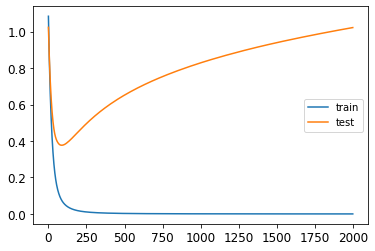

CPU times: user 48.4 s, sys: 4.62 s, total: 53 s
Wall time: 1min 22s


In [ ]:
%%time
# Note this code block should take around 1 minute to run

# define model
model = Sequential()
model.add(Dense(500, input_dim=3, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2000, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# Import dropout
from tensorflow.keras.layers import Dropout

With dropout:

Train: 0.967, Test: 0.786


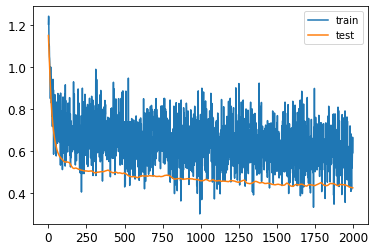

CPU times: user 48.7 s, sys: 4.77 s, total: 53.4 s
Wall time: 1min 22s


In [ ]:
%%time
# Note this code block should take around 1 minute to run

# define model
model = Sequential()
model.add(Dropout(rate=0.5)) # Dropout input neurons
model.add(Dense(500, input_dim=3, activation='relu'))
model.add(Dropout(rate=0.8)) # Dropout hidden neurons
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2000, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

As we can see, dropout seems to prevent the model from overfitting. The volatility in the training accuracy is due to the fact that we are effectively running a different model on each iteration.

### Exercise

Following fashion_mnist dataset from Keras Dataset is loaded and reshaped.

In [ ]:
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Reshaping data
num_pixels = x_train.shape[1] * x_train.shape[2]
x_train = x_train.reshape((x_train.shape[0], num_pixels)).astype('float32') /255
x_test = x_test.reshape((x_test.shape[0], num_pixels)).astype('float32')/ 255


Try to build a deep learning model and also use `Dropout Layer` to regularize

In [ ]:
#your work here




In [ ]:
#your work here

#### Solution

In [ ]:
# define model
model = Sequential()
model.add(Dropout(rate=0.5)) # Dropout hidden neurons
model.add(Dense(500, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(rate=0.5)) # Dropout hidden neurons
model.add(Dense(200, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(rate=0.5)) # Dropout hidden neurons
model.add(Dense(40, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(max(max(y_train), max(y_test))+1, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',  optimizer='adam', metrics=['accuracy'])

# fit model
model.fit(x_train, y_train, validation_data=(x_test, y_test),batch_size=1000, epochs=10)

Epoch 1/10
60/60 [==============================] - 1s 8ms/step - loss: 1.2679 - accuracy: 0.5264 - val_loss: 0.7025 - val_accuracy: 0.7231
Epoch 2/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7429 - accuracy: 0.7196 - val_loss: 0.5847 - val_accuracy: 0.7720
Epoch 3/10
60/60 [==============================] - 0s 5ms/step - loss: 0.6503 - accuracy: 0.7608 - val_loss: 0.5302 - val_accuracy: 0.8131
Epoch 4/10
60/60 [==============================] - 0s 6ms/step - loss: 0.5960 - accuracy: 0.7800 - val_loss: 0.4992 - val_accuracy: 0.8216
Epoch 5/10
60/60 [==============================] - 0s 5ms/step - loss: 0.5658 - accuracy: 0.7923 - val_loss: 0.4808 - val_accuracy: 0.8271
Epoch 6/10
60/60 [==============================] - 0s 5ms/step - loss: 0.5451 - accuracy: 0.7989 - val_loss: 0.4550 - val_accuracy: 0.8333
Epoch 7/10
60/60 [==============================] - 0s 5ms/step - loss: 0.5323 - accuracy: 0.8043 - val_loss: 0.4472 - val_accuracy: 0.8404
Epoch 8/10
60/60 [==

<a id="Other_Regularization_Techniques"></a>
## Other Tuning Techniques

So far in this section of the module, we have learned about the early stopping, L1/L2, and dropout regularization techniques. In most cases, these will be sufficient for training your deep neural network models. However there are a couple of other techniques that you should be aware of: **max-norm regularization** and **data augmentation**.

### Max-norm Regularization

- This technique constrains the weight sizes of the incoming connections in each layer such that $\left\|w\right\| ≤ r$, where $r$ is the max-norm hyperparameter and $\left\|w\right\|$ is the l2 norm of the weight parameters. Reducing r increases the amount of regularization and helps reduce overfitting. Max-norm regularization can also help alleviate the vanishing/exploding gradients problems (particularly if you are using batch normalization).


- You can implement max-norm fairly easily with keras using the `tensorflow.keras.constraints.MaxNorm` function. The code may look something like this:
    
```python
from tensorflow.keras.constraints import MaxNorm
...
mn = MaxNorm(max_value=3)
model.add(Dense(32, activation='relu', kernel_constraint=mn))
...
```
### Data Augmentation

Once your evaluation metric, model, and other associated methods are selected (your full end-to-end framework), it can be run and, potentially, improved. Your first inclination will likely be to alter some aspect of your end-to-end pipeline and examine the resulting effect on performance, but a reasonable first question is, would more data have helped?

If performance of your model on your training data is poor, it is likely that this training data is not being used effectively, so there may be little reason to collect additional data. In this case it may be beneficial to begin altering the model size (e.g. adding layers or units to each layer), adjusting the learning rate, etc. If none of these show any effect, quality of the training data may be the issue (too noisy, wrong inputs, etc), so collecting "better" data may be more of an immediate need that simply collecting more data.

Alternately, if the performance on the training set is good, but the performance on the test set is poor, gathering additional data should be highly effective in improving performance. If obtaining additional labeled data is feasible, this should be considered first. In some applications however adding data may not be possible, and so another alternative is to reduce the model size (e.g. adjusting the weight or decay coefficients) or adding/strengthening regularization.

Data augmentation is one the ways that cab help you. It consists of generating new training instances from existing ones, artificially boosting the size of your training set; this technique (if done properly) will likely help reduce overfitting. This is particularly common for audio and image classification problems. The trick here is to generate realistic training instances; ideally, a human should NOT be able to tell generated images apart from original images. Adding Gaussian white noise to expand a dataset, for instance, is very common practice; Keras actually has a ```GaussianNoise``` layer so that you can easily incorporate this method into your existing models (check out the documentation [here](https://keras.io/layers/noise/#gaussiannoise))


For image classification problems (or really almost any machine vision problem), you can also try **slightly shifting, rotating, and resizing every picture in the training set by various amounts and adding the resulting pictures to the training set.** This forces the model to be more tolerant to the position, orientation, and size of the objects in the picture you are trying to classify. By combining these transformations you can greatly increase the size of your training set. The Keras ```ImageDataGenerator``` is built specifically for these sorts of image preprocessing tasks; you can find the documentation on the Keras website [here]([https://keras.io/preprocessing/image/).

###  Default Baseline Models  

Once you have a sense of the evaluation metrics you'd like to use, the next option should be the choice of machine learning method. While neural networks will allow you to solve a host of unique learning problems, they may be overkill for others. If your problem can be solved with a simple linear model, there may be no need to introduce unnecessary complexity. However, if your problem involves object recognition, speech recognition, translation, or something similar, it is often best to begin with a simple deep learning model, adding complexity based on performance.

Selection of deep learning model will depend on the nature of the problem addressed, for example:

| Type of Input | Suggested Model |
|------------------|------------------------|
| Fixed-size vectors | Feedforward network with fully connected layers |
| Known topological structure (e.g. images) | Convolutional nework |
| Sequence | Gated recurrent net (LSTM or GRU)** |

** Transformers recently over performed RNN models for number of sequence processing tasks

#  Selecting hyperparameters

A hyperparameter for a model typically has the following characteristics:

1. It is external to the model itself, and can not be estimated by the model itself
2. It is set before the model begins learning
3. It can be tuned to improve performance of the model

Hyperparameters can be selected either manually or in an automated way. If selecting them manually, the practitioner should have a good understanding of what they do and how they affect model performance. Automatic methods for hyperparameter selection typically require less knowledge of the function of these hyperparameters, but require additional computational time as they are often found through permutation. An overall description of both manual and automatic hyperparameter selection methods is described below.

## Manual tuning

The figure below highlights both over-fitting and generalization error [generalization error](https://en.wikipedia.org/wiki/Generalization_error).

<img src="https://drive.google.com/uc?id=1F3lQLQSBIPr6ItuC8RgQt9FvVbeuBOWa">

[Source: [wikipedia.org](https://en.wikipedia.org/wiki/Generalization_error#/media/File:RegressionOverfitting.png)]

The goal of manual tuning is to reduce the generalization error, adjusting the complexity of the model to match the complexity of the task, as evaluated based on external data. The ability of a model to contain complexity is known as its **capacity**. Model capacity is affected by three things:

1. The complexity of the model (e.g. adding hidden layers will increase model capacity)
2. The ability of the model to minimize the cost function
3. The degree to which the cost function and training method regularize the model

More intricate models will have greater capacity, but that capacity will result in over-fitting without appropriate cost and regularization functions.

<img src="https://drive.google.com/uc?id=1a3wwcPyV8-AlXJ6HHOIAq88vaN6_B53U">

As you've seen previously, generalization error tends to follow this same U-shaped pattern when plotted against the value of hyperparameters. One extreme corresponds to low capacity & high generalization error (under-fitting), while the other extreme corresponds to high capacity & also high generalization error (over-fitting).

For some hyperparameters (e.g. number of hidden units in a layer), over-fitting occurs when the value is high, while for others over-fitting occurs when the value is low (e.g. weight decay coefficient). Additionally, some hyperparameters may be discrete or binary, and so may not be able to provide information on the entire curve.

A summary of key tunable parameters is shown in the table below (adapted from Goodfellow, Bengio & Courville).

|Hyperparameter     |  Increases Capacity When | Reason     | Caveats|
|-------------------|--------------------------|------------|--------|
|Number of hidden units | Increased | Increasing the number of hidden units increases the representational capacity of the model | Increasing the number of hidden units increases both the time and memory cost of essentially every operation on the model|
|Learning rate | Tuned optimally | An improper learning rate, whether too high or too low, results in a model with low effective capacity due to optimization failure | |
|Implicitly zero padding | Increased | Adding implicit zeros before convolution keeps the representation size large. | Increases time and memory cost of most operations |
|Weight decay coefficient | Decreased | Decreasing the weight decay coefficient frees the model parameters to become larger | |
|Dropout rate | Decreased | Dropping units less often gives the units more opportunities to "conspire" with each other to fit the training set | |

## Automated Tuning

While neural networks can often perform well with only a few manually tuned hyperparameters, there could potentially be dozens of hyperparameters that can be optimized for a given problem. This is both a major advantage, and disadvantage of neural networks over other classes of algorithms. Often these adjustments can be incremental when beginning from a strong starting point, but it can be the case that default values are not known or can not be easily estimated. In these cases it is useful to have an automated method to identify these hyperparameter values. Note that this is in and of itself an optimization problem, and as such uses an objective function (i.e. budget, memory, etc). Below are some common methods for automated selection of hyperparameter values. For a more detailed review, see [Bergstra & Bengio (2012)](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf).




You can find the list of known hyperparameter tuning tools below.  

* <a href="https://github.com/keras-team/keras-tuner">Keras Tuner</a>
    An easy-to-use hyperparameter optimization library Google made for Keras models, with a hosted service for visualization and analysis.
* <a href="https://github.com/hyperopt/hyperopt">Hyperopt</a>
    A popular Python library for optimizing over all sorts of complex search spaces (including real values, such as the learning rate, and discrete values, such as the number of layers).
*  <a href="https://github.com/maxpumperla/hyperas">Hyperas</a> <a href="https://github.com/Avsecz/kopt">kopt</a>, or <a href="https://github.com/autonomio/talos">Talos</a>
    Optimizing hyperparameters for Keras model (the first two are based on Hyperopt).
* <a href="https://scikit-optimize.github.io/">Scikit-Optimize</a> (skopt)
    A general-purpose optimization library. The <code>BayesSearchCV</code> class performs Bayesian optimization using an interface similar to <code>GridSearchCV</code>
* <a href="https://github.com/JasperSnoek/spearmint">Spearmint</a>
    A Bayesian optimization library.
* <a href="https://github.com/zygmuntz/hyperband">Hyperband</a>
    A fast hyperparameter tuning library based on the recent <a href="https://homl.info/hyperband">Hyperband paper</a><sup><a data-type="noteref" id="idm46263513051448-marker" href="https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch10.html#idm46263513051448">22</a></sup> by Lisha Li et al.
* <a href="https://github.com/rsteca/sklearn-deap">Sklearn-Deap</a>
    A hyperparameter optimization library based on evolutionary algorithms, with a <code>GridSearchCV</code>-like interface.
* <a href="https://arimo.com/">Arimo</a>
* <a href="https://sigopt.com/">SigOpt</a>
* <a href="http://oscar.calldesk.ai/">Oscar</a>


### Grid search

When deciding on parameters, it would seem to be a good strategy to just systematically try combinations of parameters in a grid-like search. In a **grid search**, a small set of finite values are pre-selected covering the range of possible values of a given hyperparameter. These parameter combinations are then permuted, and the model evaluated. For example, for two parameters, you could try ten different values of each in a 10 x 10 grid. The pre-selection of hyperparameter values at regular intervals differentiates the grid search from a random search. Some notes about using a grid search:

- When performing a grid search, values are typically set on a logarithmic scale (e.g. 0.001, 0.01, 0.1, 1)
- When a "good" parameter value is identified, the grid size is typically contained and re-run, centered around the good parameter
- Due to the high computational cost, grid search typically is not optimal when there are more than 3 hyperparameters being optimized ($O(n^{m})$ for *m* parameters with *n* values

How many tests would you need to do to try 10 different values of a million parameters, not uncommon in a neural net?

####  Example

(Warning: these cells take a while to evaluate!)

Tuning Batch Size & Number of Epochs (based on tutorial found <a href="https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/">here</a>)

In [ ]:
# Load libraries
import numpy as np
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from datetime import datetime


print(str(datetime.now()))

# Set random seed
np.random.seed(0)

# Number of features
number_of_features = 10

# Generate features matrix and target vector
features, target = make_classification(n_samples = 10000,
                                       n_features = number_of_features,
                                       n_informative = 3,
                                       n_redundant = 0,
                                       n_classes = 2,
                                       weights = [.5, .5],
                                       random_state = 0)

# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = models.Sequential()
    model.add(layers.Dense(12, input_dim=number_of_features, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(features, target)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print(str(datetime.now()))

2022-09-27 03:18:57.051677


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.952900 using {'batch_size': 10, 'epochs': 50}
0.947800 (0.003429) with: {'batch_size': 10, 'epochs': 10}
0.952900 (0.003200) with: {'batch_size': 10, 'epochs': 50}
0.952700 (0.003172) with: {'batch_size': 10, 'epochs': 100}
0.947100 (0.003023) with: {'batch_size': 20, 'epochs': 10}
0.950200 (0.002750) with: {'batch_size': 20, 'epochs': 50}
0.951300 (0.004895) with: {'batch_size': 20, 'epochs': 100}
0.943600 (0.004329) with: {'batch_size': 40, 'epochs': 10}
0.948700 (0.003265) with: {'batch_size': 40, 'epochs': 50}
0.951100 (0.003541) with: {'batch_size': 40, 'epochs': 100}
0.940400 (0.005380) with: {'batch_size': 60, 'epochs': 10}
0.950400 (0.002596) with: {'batch_size': 60, 'epochs': 50}
0.949900 (0.003499) with: {'batch_size': 60, 'epochs': 100}
0.934300 (0.006608) with: {'batch_size': 80, 'epochs': 10}
0.949500 (0.003674) with: {'batch_size': 80, 'epochs': 50}
0.950200 (0.003385) with: {'batch_size': 80, 'epochs': 100}
0.934500 (0.002966) with: {'batch_size': 100, 'epochs': 

Comparative random search of the same parameter space

In [ ]:
print(str(datetime.now()))
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid)
grid_result = grid.fit(features, target)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print(str(datetime.now()))

2022-09-27 03:55:29.317844
Best: 0.952100 using {'epochs': 100, 'batch_size': 10}
0.949400 (0.003153) with: {'epochs': 50, 'batch_size': 10}
0.942500 (0.003391) with: {'epochs': 10, 'batch_size': 40}
0.951300 (0.003829) with: {'epochs': 100, 'batch_size': 40}
0.950300 (0.002943) with: {'epochs': 50, 'batch_size': 60}
0.950300 (0.003140) with: {'epochs': 100, 'batch_size': 80}
0.949700 (0.003356) with: {'epochs': 50, 'batch_size': 20}
0.952100 (0.002709) with: {'epochs': 100, 'batch_size': 10}
0.947400 (0.004116) with: {'epochs': 50, 'batch_size': 100}
0.949200 (0.003311) with: {'epochs': 100, 'batch_size': 100}
0.942700 (0.003628) with: {'epochs': 10, 'batch_size': 60}
2022-09-27 04:28:23.776383


### Random search

A less computationally expensive alternative to a grid search is a **random search**. In a random search, a marginal distribution is specified for each hyperparameter (e.g. Bernouli for binary variables). Hyperparameter values are then sampled from each distribution without any binning or discretizing. As for a grid search, once the hyperparameter values have been selected, the model is evaluated. Since multiple hyperparameter values are being modified simultaneously, random search tends to find effective solutions much more quickly than a grid search.

**Random search vs grid search**<br>
A schematic highlighting the differences between random and grid searches is shown below (originally from [Bergstra & Bengio (2012)](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf)).

<img src='https://drive.google.com/uc?id=1noGPjeYdOyYe24p_Hway18y7uaWHSCJ_'>

The figure above shows 9 trials of both a grid search (left) and random search (right) for values of 2 hyperparameters with low dimensionality. The grid search on the left uses three possible discritized values for each of the 2 hyperparameters, while the random search on the right uses no binning/discritization. The effect of each hyperparameter on model performance can be seen in the green (for the parameter on the x-axis) and the yellow (for the parameter on the y-axis) plots, with one parameter having a much greater impact on model performance (green or x-axis). In the 9 trials, the grid search only attempts 3 distinct values of any given hyperparameter, while the random search provides much more information on the location of an optimal value.

#### Example

The Keras Tuner is a library that helps you pick the optimal set of hyperparameters for your TensorFlow program. The first step to work with Keras Tuner is install and import the Keras Tuner. You can install the package by using following command.

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 135 kB 8.0 MB/s 
     |████████████████████████████████| 1.6 MB 63.3 MB/s 


In [ ]:
import keras_tuner as kt

In this example, you will use the Keras Tuner to find the best hyperparameters for a machine learning model that classifies images of clothing from the Fashion MNIST dataset.

In [ ]:
(img_train, label_train), (img_test, label_test) = tf.keras.datasets.fashion_mnist.load_data()

Following we are normalizing pixel values between 0 and 1

In [ ]:
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

When you build a model for hypertuning, you also define the hyperparameter search space in addition to the model architecture.You can define a hypermodel through two approaches:

* By using a model builder function
* By subclassing the HyperModel class of the Keras Tuner API

Following we are building a builder function

In [ ]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [ ]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=5)

In [ ]:
tuner.search(img_train, label_train, epochs=5, validation_data=(img_test, label_test))
best_model = tuner.get_best_models()[0]

Trial 5 Complete [00h 00m 42s]
val_loss: 0.4073510468006134

Best val_loss So Far: 0.3565041124820709
Total elapsed time: 00h 02m 57s


### Random Search

Random Search is a parallelizable algorithm that is in our favor but the problem is that for high dimensional data it is very slow and inefficient. In Random Search we might be spending time/resources on configurations which have poor performance even from the start. So why not identify these poor configurations from the start and remove them from our search space? This approach is called **Successive Halving**.

The idea behind the original Successive Halving algorithm follows directly from its name: uniformly allocate a budget (training time, CPU cycles or ...) to a set of hyperparameter configurations, evaluate the performance of all configurations, throw out the worst half, and repeat until one configuration remains. The algorithm allocates exponentially more resources to more promising configurations.

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_successive_halving_iterations_001.png">


Unfortunately, SuccessiveHalving requires the number of configurations $n$ as an input to the algorithm. Given some finite budget $B$, $B/n$ resources are allocated on average across the configurations. However, we might face two situations;

* With big $n$ (many configurations) we will have a small average training time. Some of the configurations might not be performing very well at the beginning but have better overall results. You can see an example below;

<img src='https://drive.google.com/uc?id=1_Juq136YyLXz6EpDenJ0PDiPmL5JHTgp'>


* With a small number of configurations and having longer average training times. However, with the small number, you will miss many configurations which they might perform better.



[**Hyperband**](https://arxiv.org/pdf/1603.06560.pdf) addresses this “$n$ versus $B/n$” problem by considering several possible values of $n$ for a fixed B. The other way to look into it is by performing a grid search over the feasible value of $n$. Hyperband has two main parts;


* the inner loop invokes SuccessiveHalving for fixed values of $n$(number of configurations) and $r$ (resource)

* the outer loop iterates over different values of $n$ and $r$


The way to use Hyperband with `Keras Tuner` is easy. As you see in the following example you can `Hyperband` class from `Keras Tuner` package.  








In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

There are two parameters which are important to pass when you can Hyperband.

  * **max_epochs**: the maximum number of epochs to train one model. It is recommended to set this to a value slightly higher than the expected epochs to convergence for your largest Model, and to use early stopping during training (for example, via tf.keras.callbacks.EarlyStopping).

* **factor**: the reduction factor for the number of epochs and number of models for each outer loop. Its default value is 3.

In [ ]:
tuner.search(img_train, label_train, epochs=5, validation_data=(img_test, label_test))
best_model = tuner.get_best_models()[0]

Trial 27 Complete [00h 00m 51s]
val_accuracy: 0.8791999816894531

Best val_accuracy So Far: 0.8791999816894531
Total elapsed time: 00h 08m 34s

Search: Running Trial #28

Value             |Best Value So Far |Hyperparameter
96                |480               |units
0.0001            |0.0001            |learning_rate
10                |10                |tuner/epochs
0                 |0                 |tuner/initial_epoch
0                 |0                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/10
1599/1875 [========================>.....] - ETA: 0s - loss: 0.7791 - accuracy: 0.7496

KeyboardInterrupt: ignored

In [ ]:
# note: the above was deliberately interrupted to halt the param search

#  Debugging strategies

When model performance is poor, it can often be difficult to determine if there was a bug in the code itself, or there was improper construction of the model. Similarly, unrealistically high performance may also indicate an error in the code or model setup that should be addressed. Further complementing this difficulty, machine learning models can be adaptive, meaning they can achieve reasonable performance even when one component of the model is broken. For these reasons, debugging strategies for neural networks typically either use a very simplified test case (where the outcome could be easily determined and verified), or test each of the individual components in isolation.

These are important tasks to consider when debugging a neural network model:

- **Visualize the model output:** Select a random subset of model predictions and manually examine for accuracy. If possible, identify where the model misclassified inputs and examine if this was due to a systematic error.
- **Fit a small and/or well-characterized dataset:** If model performance is difference than that expected, it's possible a software or implementation issue is the cause. It's often useful to use a simplified implementation of your model to verify that results match your expectation.

# References

Géron, A. (2017). Chapter 11: Training Deep Neural Nets in Hands-On Machine Learning with Scikit-Learn and TensorFlow O’Reilly Media http://shop.oreilly.com/product/0636920052289.do![image.png](attachment:image.png)

TensorFlow documentation and tutorials: https://www.tensorflow.org/tutorials

Keras documentation and tutorials: https://keras.io/

Scikit-learn: https://scikit-learn.org/